In [66]:
import numpy as np
import matplotlib.pyplot as plt
from forecast.core import compare_fisher_matrices, FisherMatrix
from scipy.interpolate import interp2d
import pandas as pd
from general_definitions import  rep_path, set_mpl, vapeplot, path2plots
set_mpl()
from calculate_cosmo import sigmas_all, f_fails_all, sigmas_agn_ignore
sigmas_agn = [x for x in sigmas_all if x not in sigmas_agn_ignore]

palette = vapeplot.palette('vaporwave')
plot_args = {'linewidths': [2, 2, 3], 'shade': True,  'shade_alpha': 0.4, 'sigmas': [1], 'label_font_size': 20, 'tick_font_size': 15, 'colors': palette, 
'linestyles': ['--', '--', '-'], 'legend_kwargs':{'title':r'Tracer ($sigma_0$, $f_{{\rm fail}}$)', 'fontsize': 15}}

%matplotlib inline
savepath = rep_path + 'forecast/Fisher_matrices/impact-photoz-cosmology/data/'


set palette to mallsoft, shuffle=False
set matplotlib rc


In [67]:
def load_fisher_sigma0_f_fail(sigma_0, f_fail,):
    setname_clu = f'Clusters_{sigma_0}_{f_fail}'
    fname_clu = savepath + f'{setname_clu}.npz'
    setname_agn = f'AGN_{sigma_0}_{f_fail}'
    fname_agn = savepath + f'{setname_agn}.npz'
    Fs = []
    for fname, setname in zip([fname_clu, fname_agn], [setname_clu, setname_agn]):
        try:
            arr = np.load(fname, allow_pickle=True)
            pars = arr['pars']
            par_names = arr['par_names']
            F = arr['F']
            J = arr['J']
            comp=setname.split('_')
            Fname = f'{comp[0]}({comp[1]},{comp[2]})'
            F = FisherMatrix(par=pars, par_names=par_names, F=F,
                                J=J, name=Fname, function=lambda x: x)
            F = F.transform_to_Om()
            #F.check_derivatives()
            Fs.append(F)
        except FileNotFoundError:
            #print(f'{fname} not found')
            Fs.append(None)
    return Fs



In [68]:
#load_fisher_sigma0_f_fail(0.015, 0.01)[0].name

In [69]:
df_cosmo = pd.DataFrame(columns=['sigma_0', 'f_fail', 'F_agn', 'F_clu'])
Fs = []
idx = 0
for sigma_0 in sigmas_all:
    for f_fail in f_fails_all:
        Fs_tmp = load_fisher_sigma0_f_fail(sigma_0, f_fail)
        df_cosmo = df_cosmo.append({'sigma_0': sigma_0, 'f_fail': f_fail, 'F_agn': Fs_tmp[1], 'F_clu': Fs_tmp[0]}, ignore_index=True)
        Fs.append([Fs_tmp[0], Fs_tmp[1]])
        idx += 1

In [70]:
Fs[-5][0].name

'Clusters(0.005,0.01)'

In [71]:
Fs[-2][0].F
np.log10(np.pi/np.sqrt(np.linalg.det(np.linalg.inv(Fs[-2][0].F))))

8.849424739322874

In [72]:
print([Fs[i][0].name for i in range(-10, -1)])
[np.log10(np.pi/np.sqrt(np.linalg.det(np.linalg.inv(Fs[i][0].F)))) for i in range(-10, -1)]

['Clusters(0.01,0.01)', 'Clusters(0.01,0.02)', 'Clusters(0.01,0.05)', 'Clusters(0.01,0.1)', 'Clusters(0.01,0.2)', 'Clusters(0.005,0.01)', 'Clusters(0.005,0.02)', 'Clusters(0.005,0.05)', 'Clusters(0.005,0.1)']


[8.447156181659448,
 8.426800710775298,
 8.36433604066359,
 8.255175808294089,
 8.014113106706857,
 9.04758828399672,
 9.026616640107328,
 8.962205808733763,
 8.849424739322874]

In [73]:
print([Fs[i][0].name for i in range(-15, -8)])
[np.log10(np.pi/np.sqrt(np.linalg.det(np.linalg.inv(Fs[i][0].F)))) for i in range(-15, -8)]

['Clusters(0.015,0.01)', 'Clusters(0.015,0.02)', 'Clusters(0.015,0.05)', 'Clusters(0.015,0.1)', 'Clusters(0.015,0.2)', 'Clusters(0.01,0.01)', 'Clusters(0.01,0.02)']


[8.011280544452124,
 7.991174219887303,
 7.929585757554328,
 7.822302680084865,
 7.5872035179841095,
 8.447156181659448,
 8.426800710775298]

In [74]:

pessimistic_agn_id = 18
conservative_agn_id =  23
optimistic_agn_id =  28

pessimistic_clu_id = 32
conservative_clu_id = 41
optimistic_clu_id = 45

#df_cosmo


In [78]:
s_all, f_all = np.meshgrid(sigmas_all, f_fails_all)
s_agn, f_agn = np.meshgrid(sigmas_agn, f_fails_all)


def cosmo_significance(si, fi, kind='FoM', type='AGN',
                       p1_id=0, p2_id=4,
                       factor=1, ):
    # to compare with huetsi2014 use factor np.sqrt(1/(0.658) (to make f_sky = 1)

    if type == 'AGN':
        F =  df_cosmo.query('(f_fail == @fi) & (sigma_0 == @si)')['F_agn'].values[0]
    elif type == 'Clusters':
        F = df_cosmo.query('(f_fail == @fi) & (sigma_0 == @si)')['F_clu'].values[0]
    else:
        raise ValueError(f'Type {type} not recognized')
    
    cov = np.linalg.inv(F.F*factor)

    if kind == 'FoM':
        cov_reduced = np.array([[cov[p1_id][p1_id], cov[p1_id][p2_id]], [
                               cov[p2_id][p1_id], cov[p2_id][p2_id]]])
        FoM_trans = np.pi/np.sqrt(np.linalg.det(cov_reduced))
        label = f'FoM ({F.par_names[p1_id]}, {F.par_names[p2_id]})'
        return FoM_trans, label
    # elif kind == 'snr':
    #     par_error = np.sqrt(np.diag(cov))[p1_id]
    #     sign = 100*par_error/F.par[p1_id]
    #     label = f'{F.par_names[p1_id]} SNR, %'
    #     return sign, label

    elif kind == 'FoM_all':
        FoM = np.pi/np.sqrt(np.linalg.det(cov))
        label = 'FoM'
        return np.log10(FoM), label
    else:
        raise ValueError('kind must be FoM or FoM_all')



In [79]:
set_mpl()


def log_interp2d(xx, yy, zz,  kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    logz = np.log10(zz)
    lin_interp = interp2d(logx, logy, logz, kind=kind)
    def log_interp(xx, yy): return np.power(
        10.0, lin_interp(np.log10(xx), np.log10(yy)))
    return log_interp


def plot_results(kind='FoM',  type='AGN', p1_id=0, p2_id=4, interp='linear', cmap='GnBu', fsky=0.658):
    vcosmo_significance = np.vectorize(cosmo_significance)
    if type == 'AGN':
        s = s_agn
        f = f_agn
        sigmas = sigmas_agn
        f_fails = f_fails_all
    else:
        s = s_all
        f = f_all
        sigmas = sigmas_all
        f_fails = f_fails_all

    sign, sign_label = vcosmo_significance(
        s, f, kind=kind, type=type, p1_id=p1_id, p2_id=p2_id, factor=fsky/0.658)
    sign_label = sign_label[0][0]

    fig1 = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.5)
    rows, cols = 2, 5
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=2, colspan=3)
    ax_slice1 = plt.subplot2grid((rows, cols), (0, 3), rowspan=1, colspan=2)
    ax_slice2 = plt.subplot2grid((rows, cols), (1, 3), rowspan=1, colspan=2)
    if 'log' in interp:
        interp = interp.replace('log', '')
        interp_err = log_interp2d(s, f, sign, kind=interp)
    else:
        interp_err = interp2d(s, f, sign, kind=interp)
    xnew = np.geomspace(np.min(sigmas), np.max(sigmas), 99)
    ynew = np.geomspace(np.min(f_fails), np.max(f_fails), 99)
    sign_int = interp_err(xnew, ynew)
    s_int, f_int = np.meshgrid(xnew, ynew)
    im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)
    cp = ax.contour(s_int, f_int, sign_int, 10, colors=[
                    'k'], linestyles='-.', linewidths=2, alpha=0.5)
    ax.clabel(cp, inline=1, fontsize=15, fmt='%1.2f')
    cbar = fig1.colorbar(im2, ax=ax)
    cbar.set_label(sign_label, rotation=90, labelpad=20)
    # for im in plt.gca().get_images():
    #    im.set_clim(3, 1)

    ax.scatter(s, f, marker='o', c=sign, s=40, label='sampled', cmap=cmap)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_0$')
    ax.set_ylabel(r'$f_{\rm fail}$')
    ax.set_title(sign_label + f', {type}; ' + r"$f_{\rm sky}$" + f'={fsky}')
    ax.set_xlim(0.9*np.min(sigmas), 1.1*np.max(sigmas))
    ax.set_ylim(0.9*np.min(f_fails), 1.1*np.max(f_fails))
    ax.set_xticks([0.005, 0.01, 0.02, 0.03, 0.04,
                   0.05, 0.06, 0.07, 0.1, 0.2, 0.3])
    ax.set_xticks(ax.get_xticks()[::1])

    for f_fail in f_fails:
        sign_axis = [cosmo_significance(
            s, f_fail, kind=kind, type=type, p1_id=p1_id, p2_id=p2_id, factor=fsky/0.658)[0] for s in sigmas]

        ax_slice1.loglog(sigmas, sign_axis, '-.', lw=3,
                         alpha=0.8, label=f'{f_fail}')
        ax_slice1.set_xlabel(r'$\sigma_0$')
        #ax_slice1.set_ylabel('BAO SNR')
        ax_slice1.legend(fontsize=15, title=r'$f_{\rm fail}$', loc=(1.04, 0.4))

    for sigma in sigmas:
        sign_axis = [cosmo_significance(
            sigma, f, kind=kind, type=type, p1_id=p1_id, p2_id=p2_id, factor=fsky/0.658)[0] for f in f_fails]
        ax_slice2.semilogx(f_fails, sign_axis, '-.', lw=3,
                           alpha=0.8, label=f'{sigma}')
        ax_slice2.set_xlabel(r'$f_{\rm fail}$')
        ax_slice2.legend(fontsize=15, title=r'$\sigma_0$', loc=(1.04, 0.4))

    # for f_fail in f_fails:
    #     saxis = np.linspace(np.min(s), np.max(s), 100)
    #     def tmp_f(s): return interp_err(s, f_fail)
    #     ax_slice1.loglog(saxis, tmp_f(saxis), ls='--',
    #                      alpha=0.9, label=f'{f_fail}')
    #     color = ax_slice1.get_lines()[-1].get_color()
    #     ax_slice1.plot(sigmas, tmp_f(sigmas)[::-1], 'o', color=color, ms=5)
    #     ax_slice1.set_xlabel(r'$\sigma_0$')
    #     ax_slice1.set_ylabel(sign_label)
    #     ax_slice1.legend(fontsize=15, title='f_fail', loc=(1.04, 0.4))
    #     del tmp_f
    # for sigma in sigmas:
    #     faxis = np.linspace(np.min(f), np.max(f), 100)
    #     def tmp_f(f): return interp_err(sigma, f)
    #     ax_slice2.loglog(faxis, tmp_f(faxis), ls='--',
    #                      alpha=0.9, label=f'{sigma}')
    #     color = ax_slice2.get_lines()[-1].get_color()
    #     ax_slice2.plot(f_fails, tmp_f(f_fails), 'o', ms=5, color=color)

    #     ax_slice2.set_xlabel(r'$f_{\rm fail}$')
    #     ax_slice2.set_ylabel(sign_label)
    #     ax_slice2.legend(fontsize=15, title='sigma_0', loc=(1.04, 0.4))
    #     del tmp_f

    return s, f, sign, s_int, f_int, sign_int


set palette to mallsoft, shuffle=False
set matplotlib rc


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_21307/4216867656.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)
/Users/sdbykov/opt/anaconda3/envs/venv_science/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=13,10 m=50 fp=0.000114 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_21307/4216867656.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y

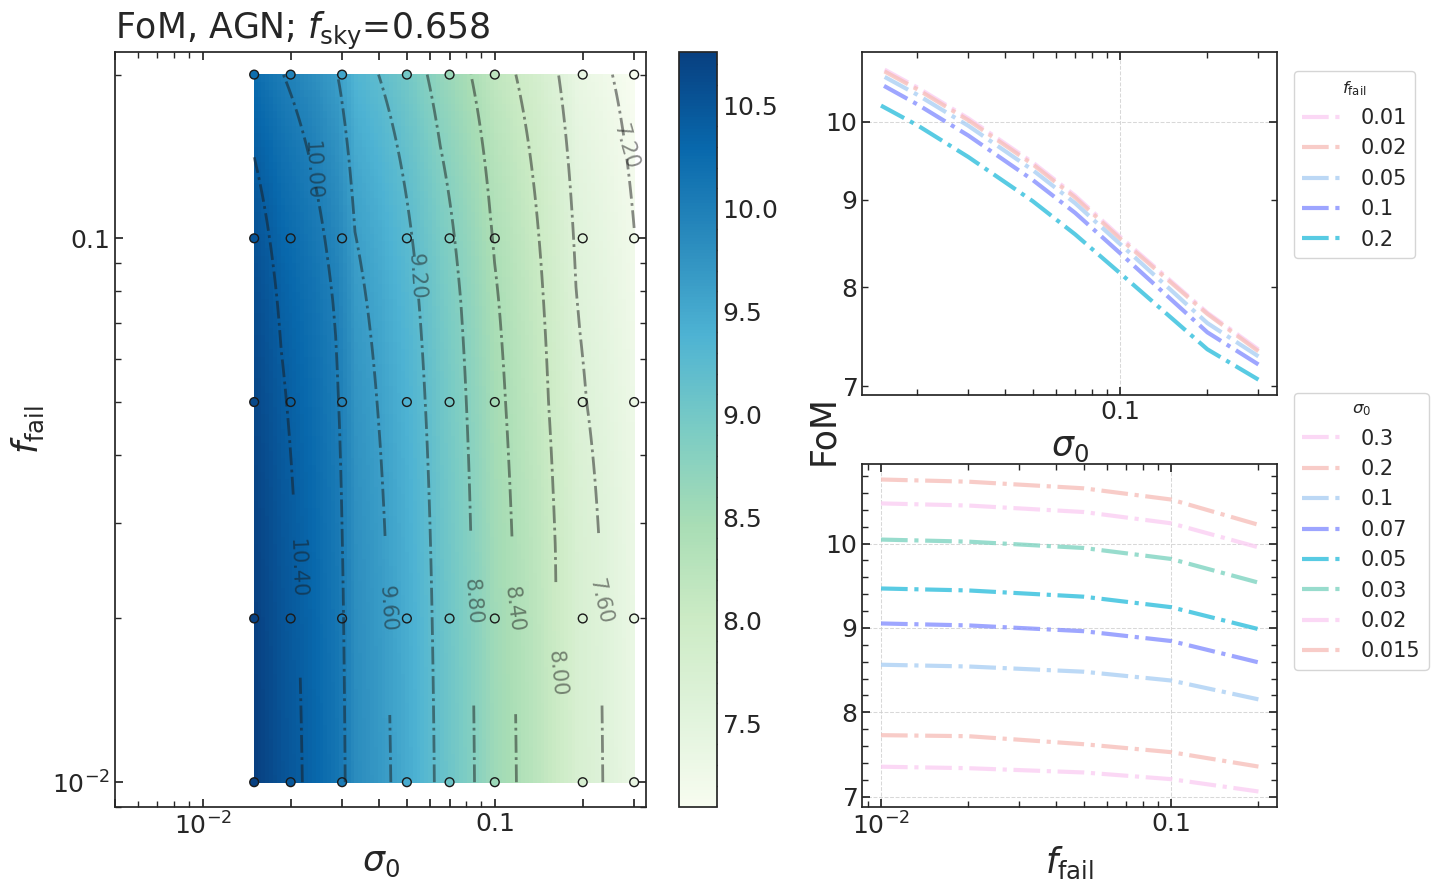

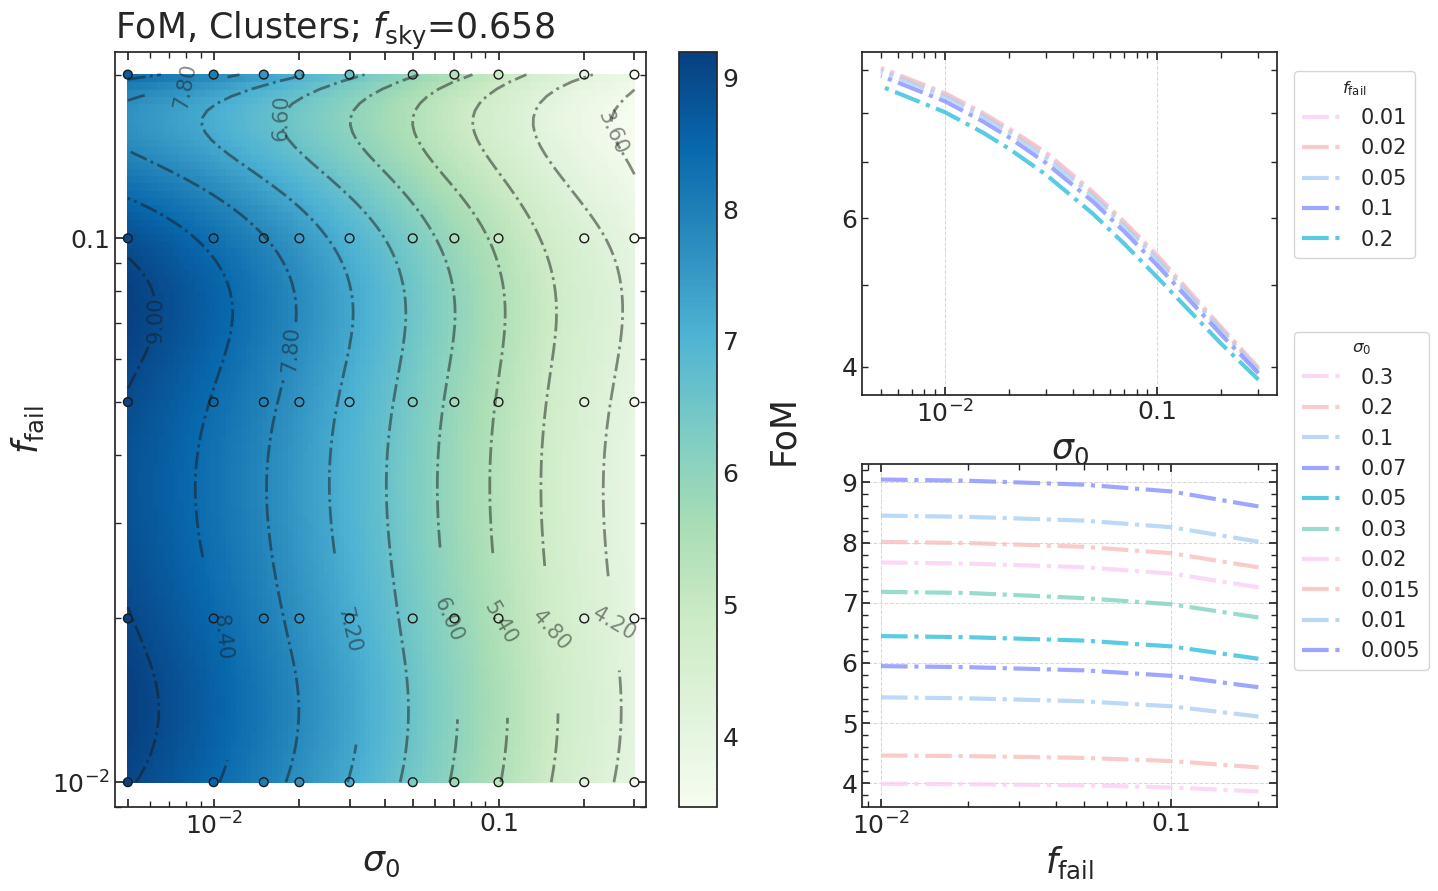

In [80]:
#plot_results(kind = 'FoM_all', p1_id = 0, p2_id = 2, interp = 'loglinear', cmap = matplotlib.colors.ListedColormap(vapeplot.palette('avanti')));
plot_results(kind = 'FoM_all', p1_id = 0, p2_id = 2, interp = 'linear', cmap = 'GnBu');
plt.savefig(f'{path2plots}/cosmo_forecast/photoz-cosmo_agn.pdf')

plot_results(kind = 'FoM_all', p1_id = 0, p2_id = 2, type = 'Clusters',interp = 'cubic', cmap = 'GnBu');
plt.savefig(f'{path2plots}/cosmo_forecast/photoz-cosmo_clu.pdf')


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_21307/4142432742.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax.pcolormesh(s_int, f_int, sign_int, cmap=cmap)
/Users/sdbykov/opt/anaconda3/envs/venv_science/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=11,8 m=50 fp=0.015394 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_21307/4142432742.py:48: MatplotlibDeprecationWarning: shading='flat' when X and Y 

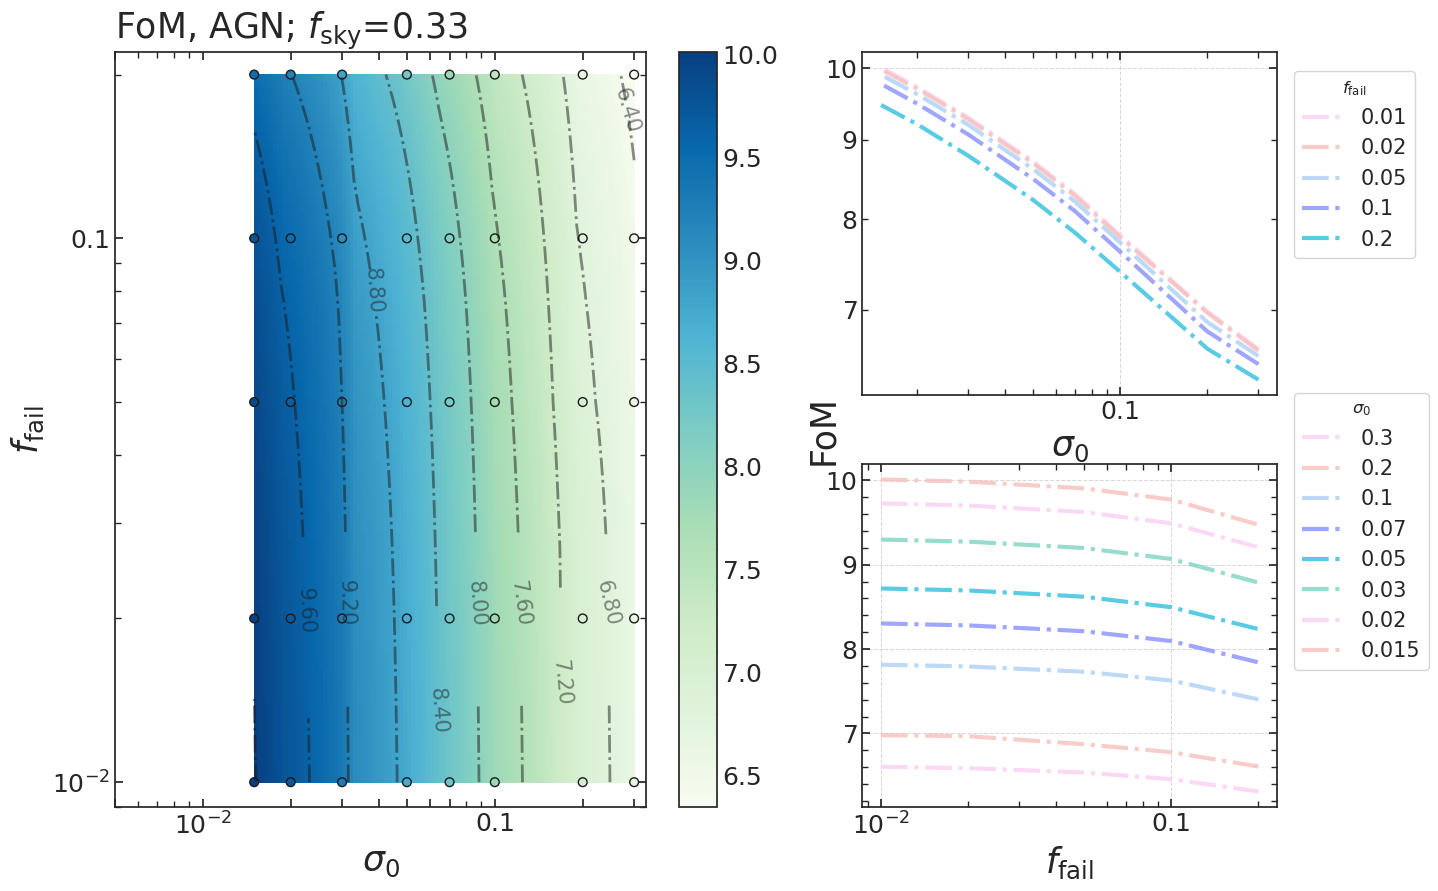

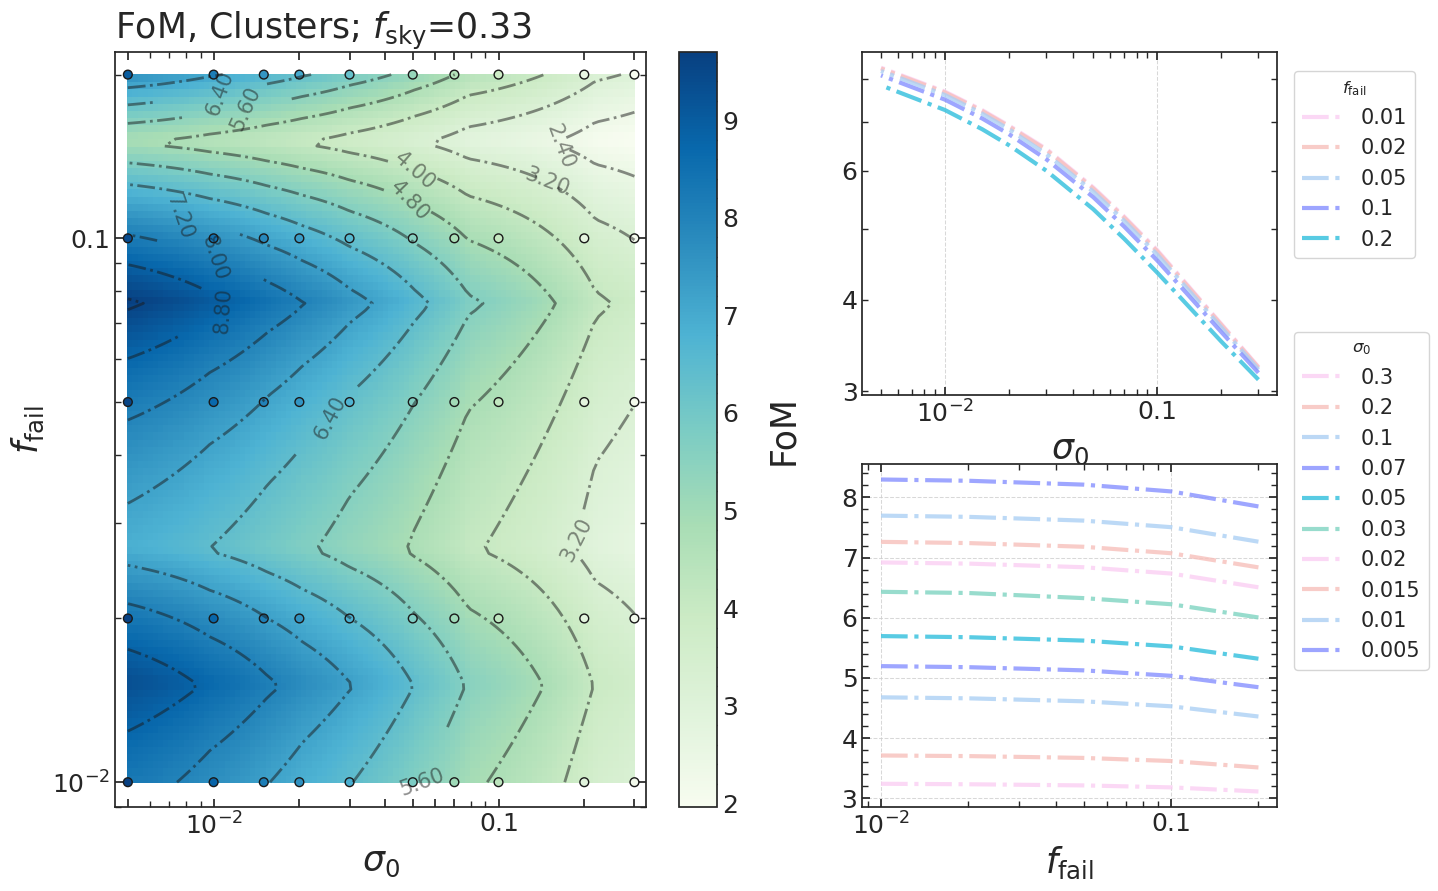

In [10]:
plot_results(kind = 'FoM_all', p1_id = 0, p2_id = 2, interp = 'linear', cmap = 'GnBu', fsky= 0.33);
plt.savefig(f'{path2plots}/talks/cosmo_forecast/photoz-cosmo_agn_ru.pdf')

plot_results(kind = 'FoM_all', p1_id = 0, p2_id = 2, type = 'Clusters',interp = 'linear', cmap = 'GnBu', fsky= 0.33 );
plt.savefig(f'{path2plots}/talks/cosmo_forecast/photoz-cosmo_clu_ru.pdf')


====== sigma_0=0.3 f_fail=0.01, index = 0 ====
====== sigma_0=0.3 f_fail=0.02, index = 1 ====
====== sigma_0=0.3 f_fail=0.05, index = 2 ====
====== sigma_0=0.3 f_fail=0.1, index = 3 ====
====== sigma_0=0.3 f_fail=0.2, index = 4 ====
====== sigma_0=0.2 f_fail=0.01, index = 5 ====
====== sigma_0=0.2 f_fail=0.02, index = 6 ====
====== sigma_0=0.2 f_fail=0.05, index = 7 ====
====== sigma_0=0.2 f_fail=0.1, index = 8 ====
====== sigma_0=0.2 f_fail=0.2, index = 9 ====
====== sigma_0=0.1 f_fail=0.01, index = 10 ====
====== sigma_0=0.1 f_fail=0.02, index = 11 ====
====== sigma_0=0.1 f_fail=0.05, index = 12 ====
====== sigma_0=0.1 f_fail=0.1, index = 13 ====
====== sigma_0=0.1 f_fail=0.2, index = 14 ====
====== sigma_0=0.07 f_fail=0.01, index = 15 ====
====== sigma_0=0.07 f_fail=0.02, index = 16 ====
====== sigma_0=0.07 f_fail=0.05, index = 17 ====
====== sigma_0=0.07 f_fail=0.1, index = 18 ====
====== sigma_0=0.07 f_fail=0.2, index = 19 ====
====== sigma_0=0.05 f_fail=0.01, index = 20 ====
====

====== sigma_0=0.05 f_fail=0.1, index = 23 ====
====== sigma_0=0.05 f_fail=0.2, index = 24 ====
====== sigma_0=0.03 f_fail=0.01, index = 25 ====
====== sigma_0=0.03 f_fail=0.02, index = 26 ====
====== sigma_0=0.03 f_fail=0.05, index = 27 ====
====== sigma_0=0.03 f_fail=0.1, index = 28 ====
====== sigma_0=0.03 f_fail=0.2, index = 29 ====
====== sigma_0=0.02 f_fail=0.01, index = 30 ====


/Users/sdbykov/work/clustering_forecast/forecast/core.py:332: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,  ax = plt.subplots(figsize=(15, 4))


====== sigma_0=0.02 f_fail=0.02, index = 31 ====
====== sigma_0=0.02 f_fail=0.05, index = 32 ====
====== sigma_0=0.02 f_fail=0.1, index = 33 ====
====== sigma_0=0.02 f_fail=0.2, index = 34 ====
====== sigma_0=0.015 f_fail=0.01, index = 35 ====


====== sigma_0=0.015 f_fail=0.02, index = 36 ====
====== sigma_0=0.015 f_fail=0.05, index = 37 ====
====== sigma_0=0.015 f_fail=0.1, index = 38 ====


====== sigma_0=0.015 f_fail=0.2, index = 39 ====
====== sigma_0=0.01 f_fail=0.01, index = 40 ====
====== sigma_0=0.01 f_fail=0.02, index = 41 ====
====== sigma_0=0.01 f_fail=0.05, index = 42 ====
====== sigma_0=0.01 f_fail=0.1, index = 43 ====
====== sigma_0=0.01 f_fail=0.2, index = 44 ====
====== sigma_0=0.005 f_fail=0.01, index = 45 ====
====== sigma_0=0.005 f_fail=0.02, index = 46 ====


====== sigma_0=0.005 f_fail=0.05, index = 47 ====
====== sigma_0=0.005 f_fail=0.1, index = 48 ====
====== sigma_0=0.005 f_fail=0.2, index = 49 ====


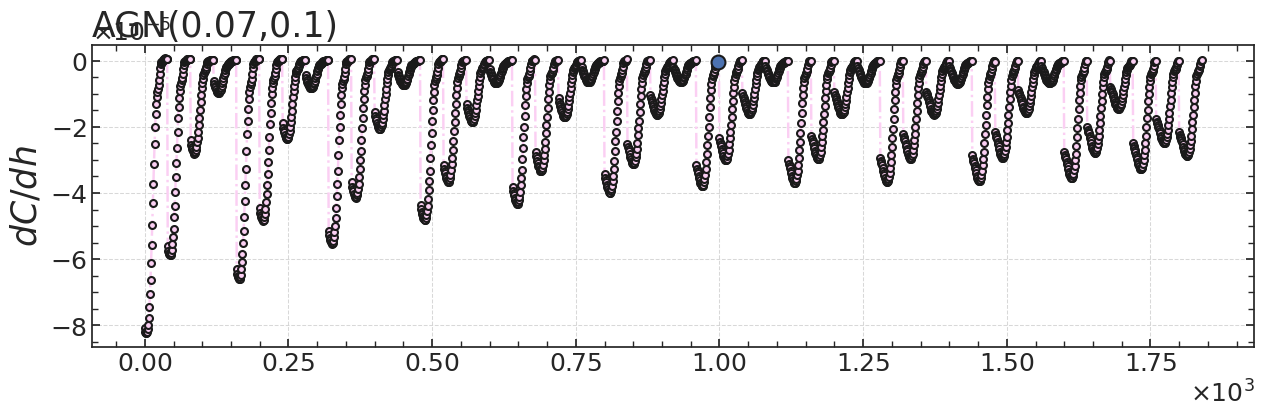

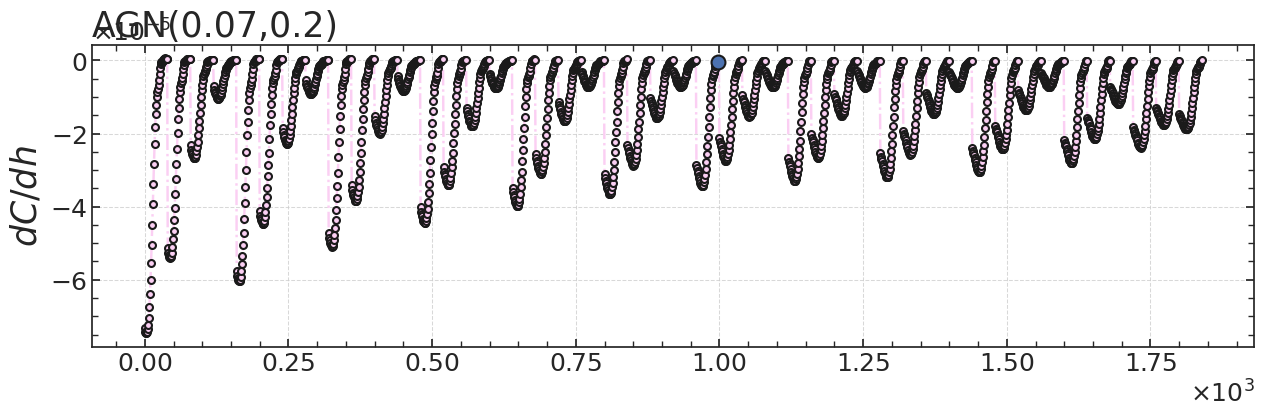

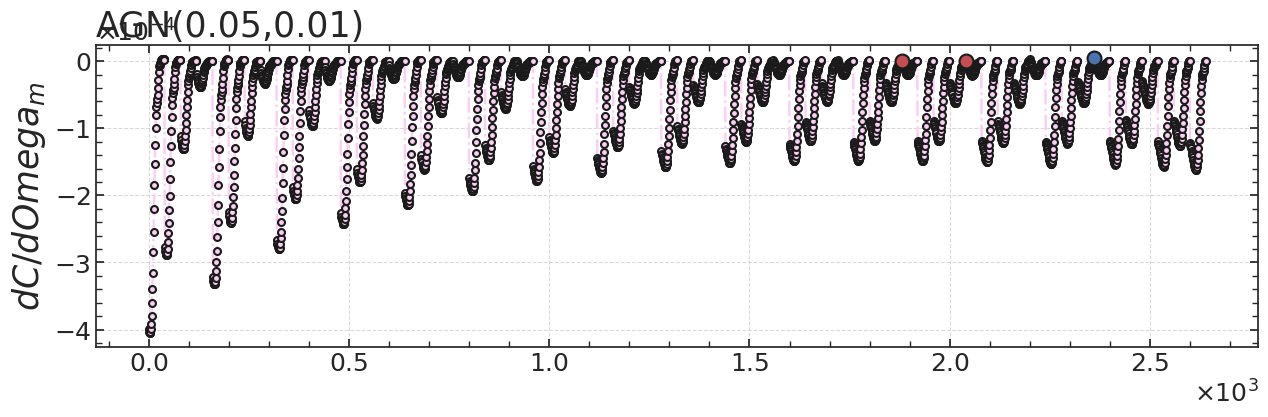

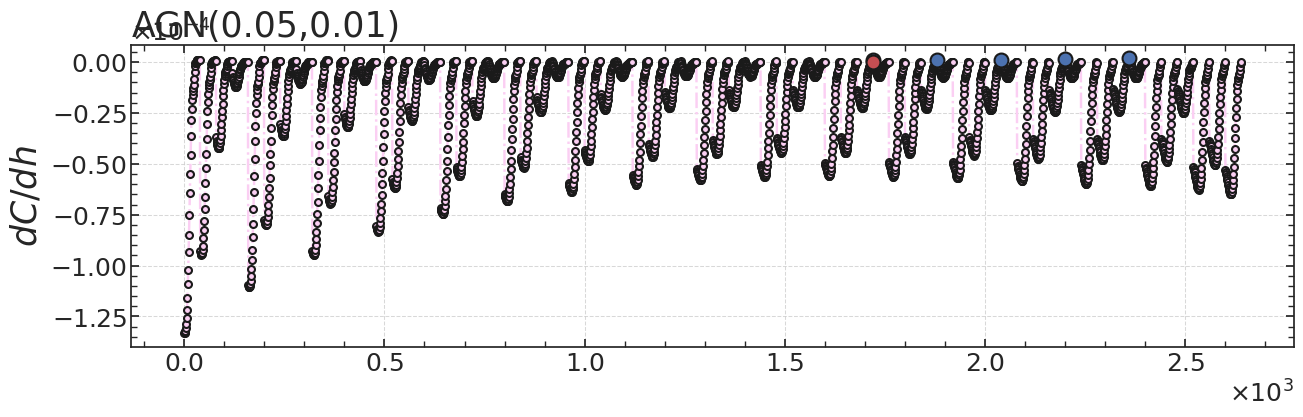

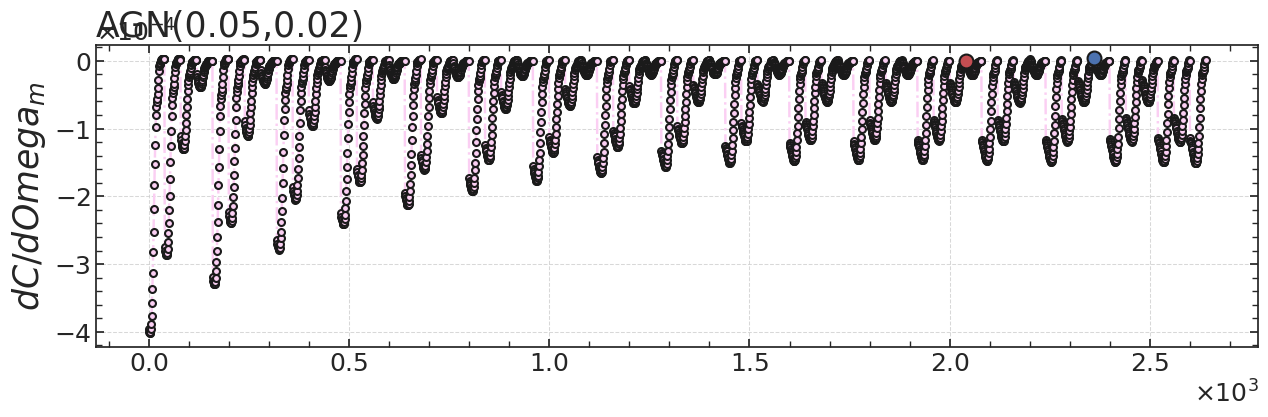

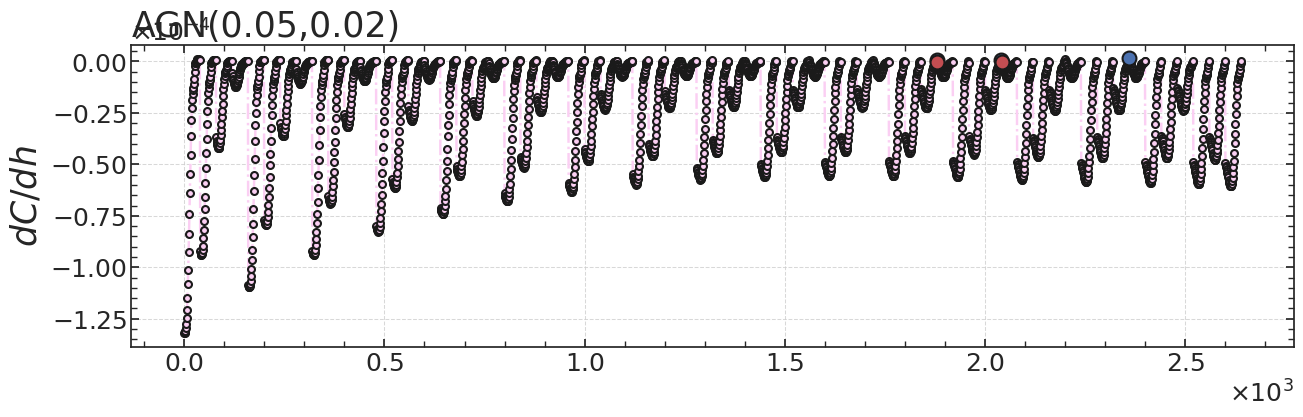

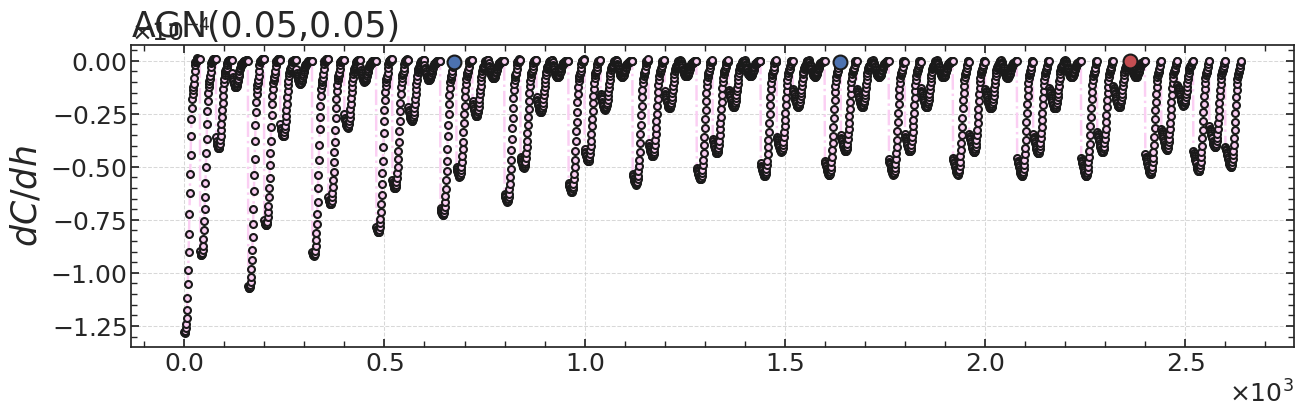

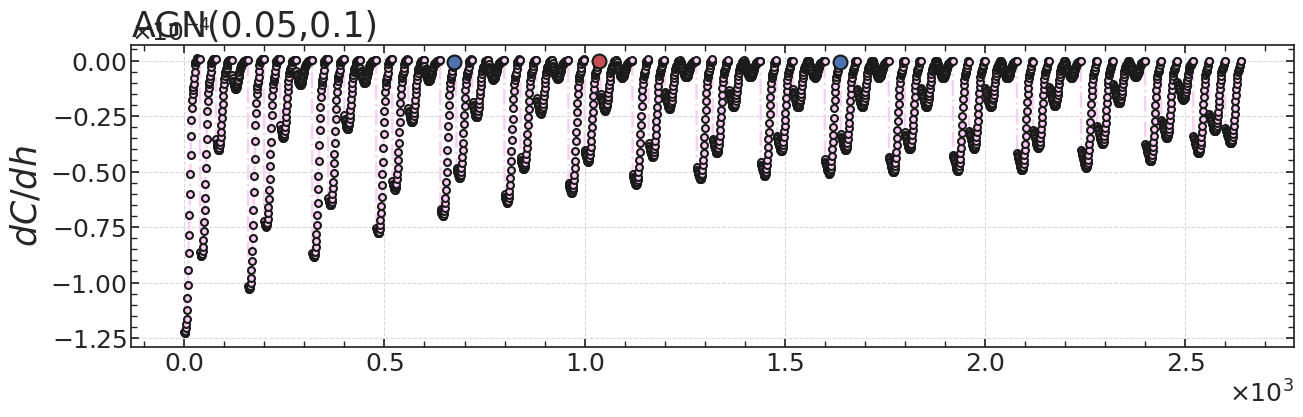

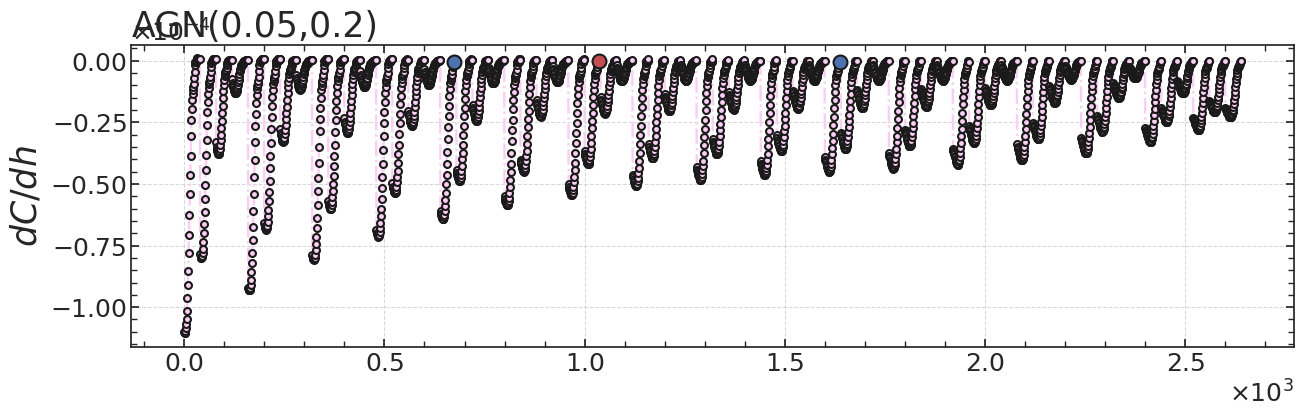

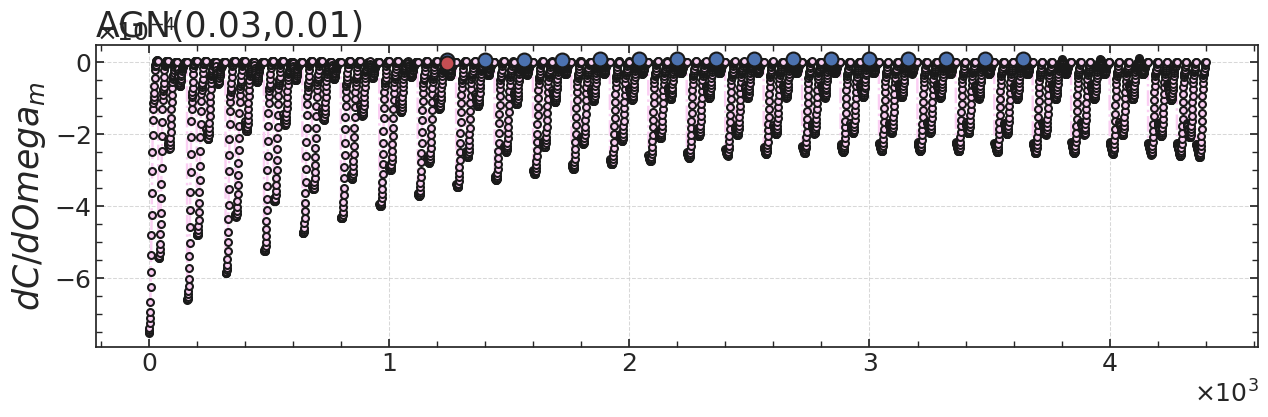

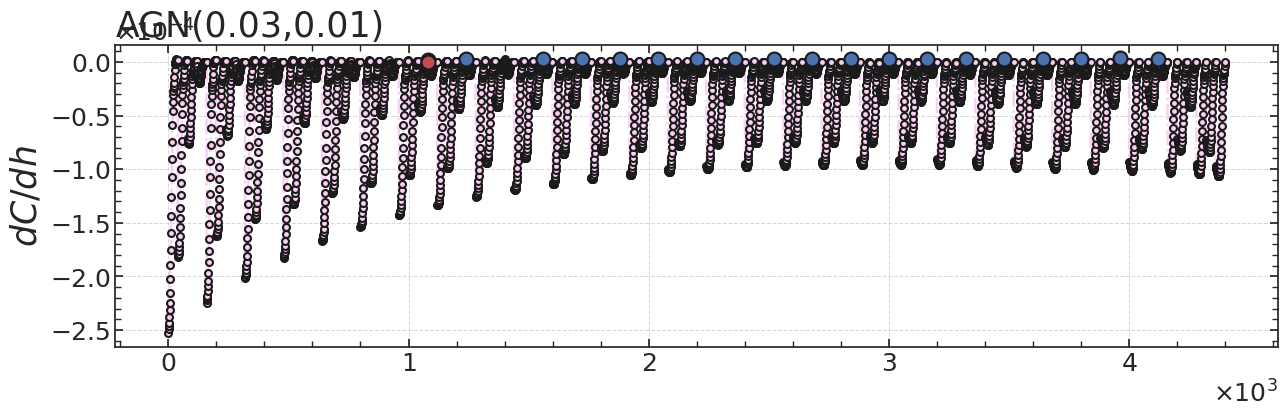

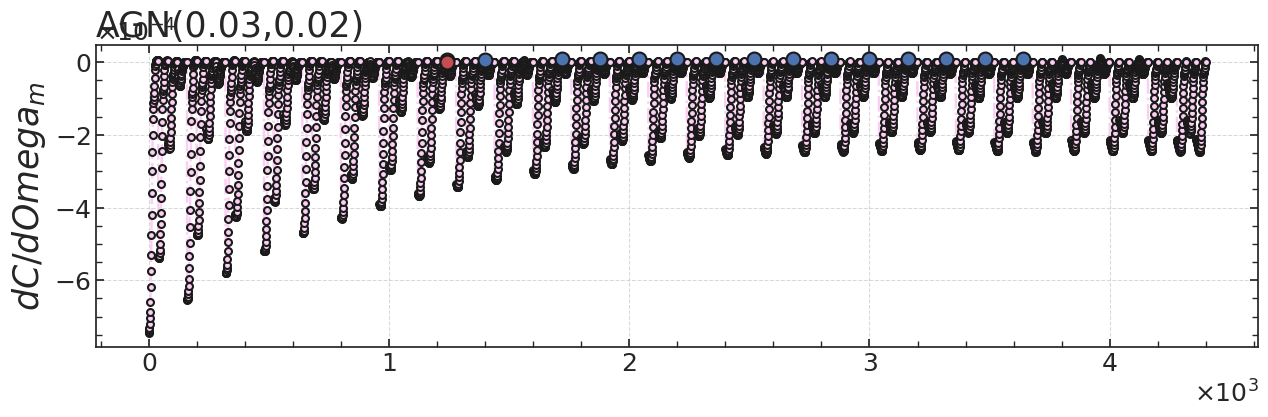

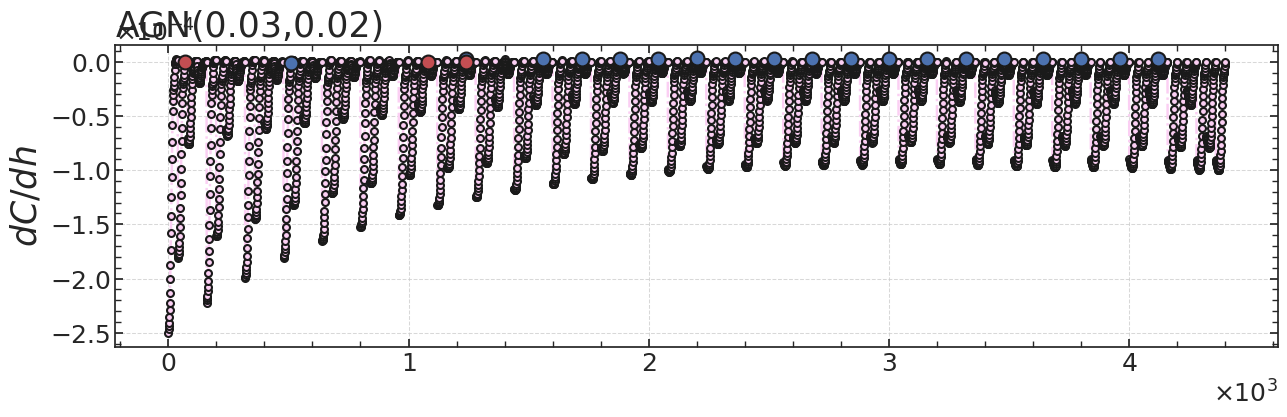

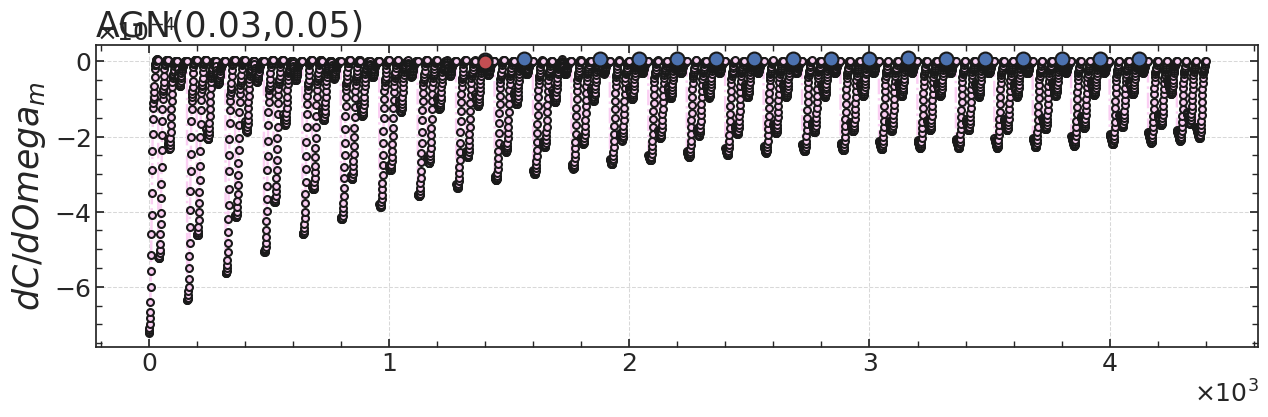

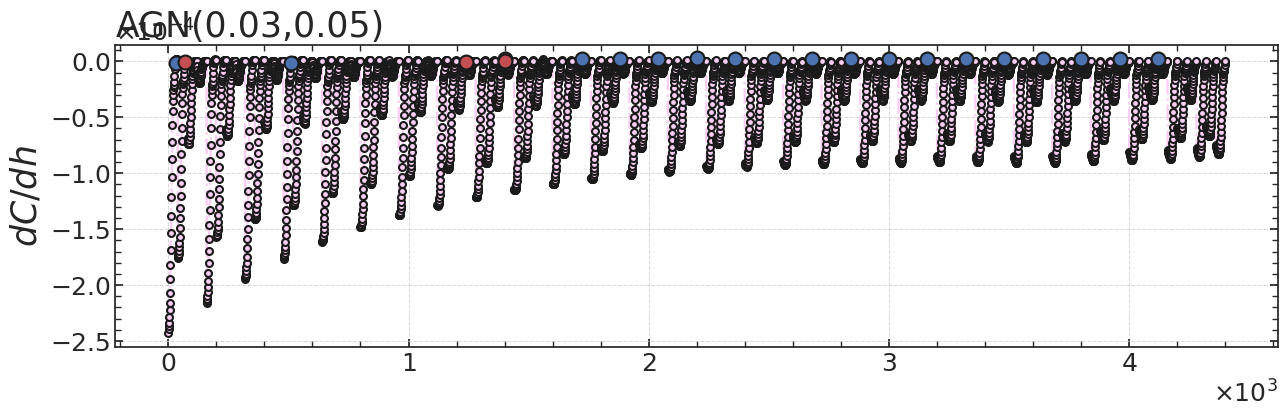

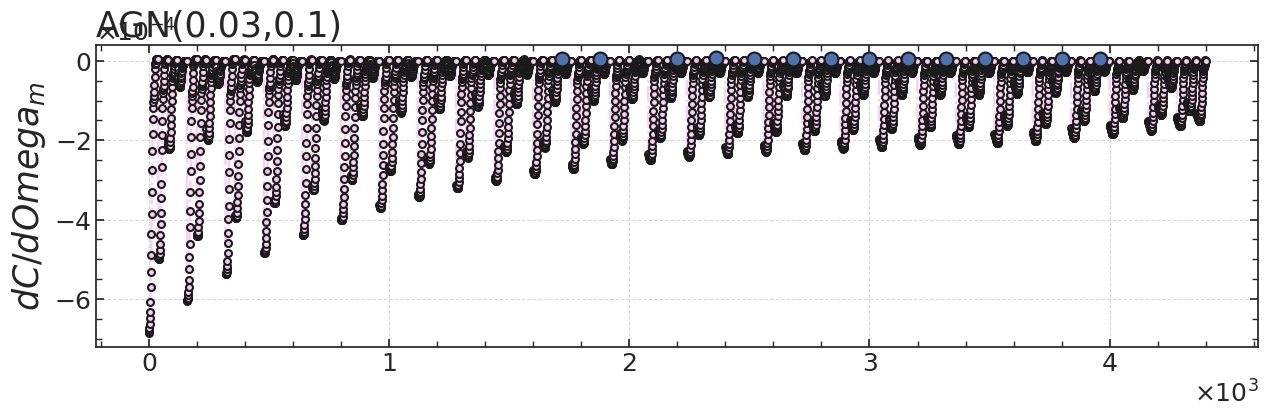

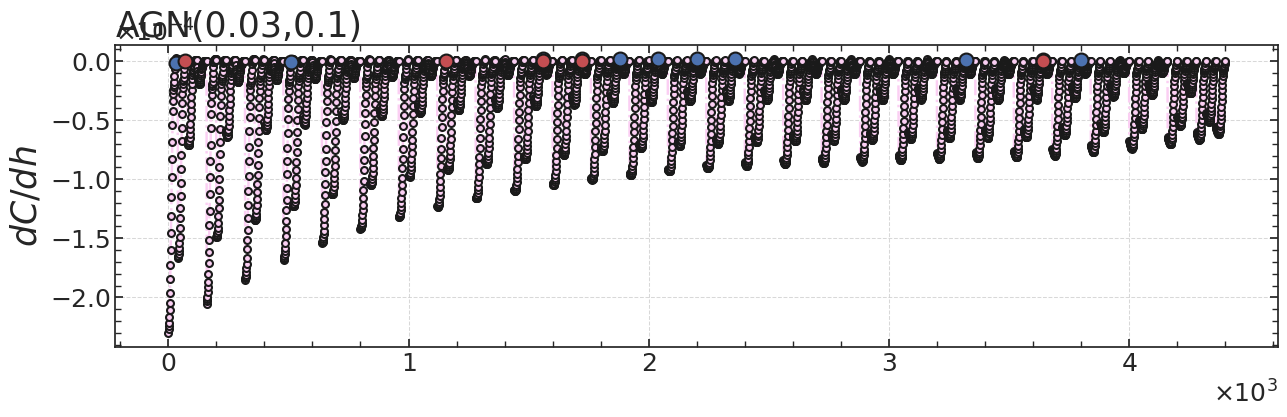

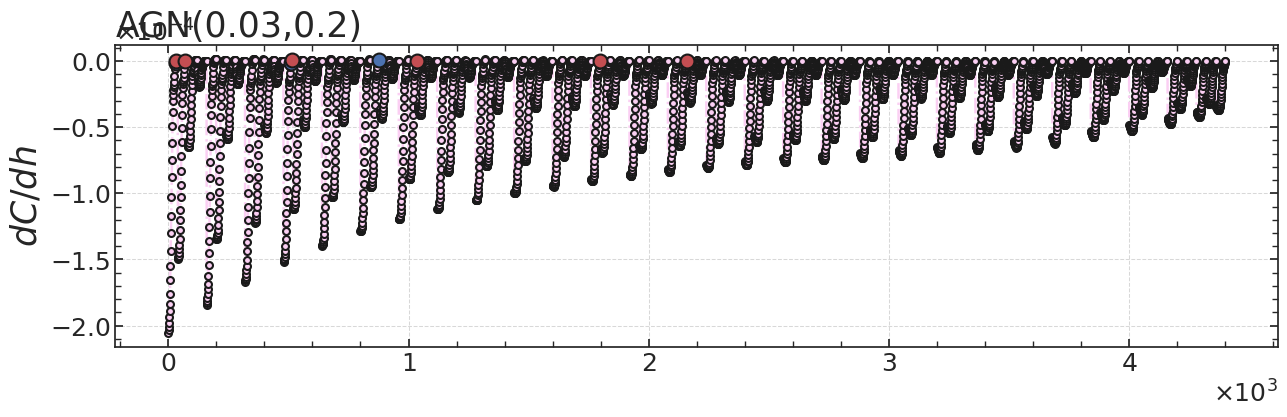

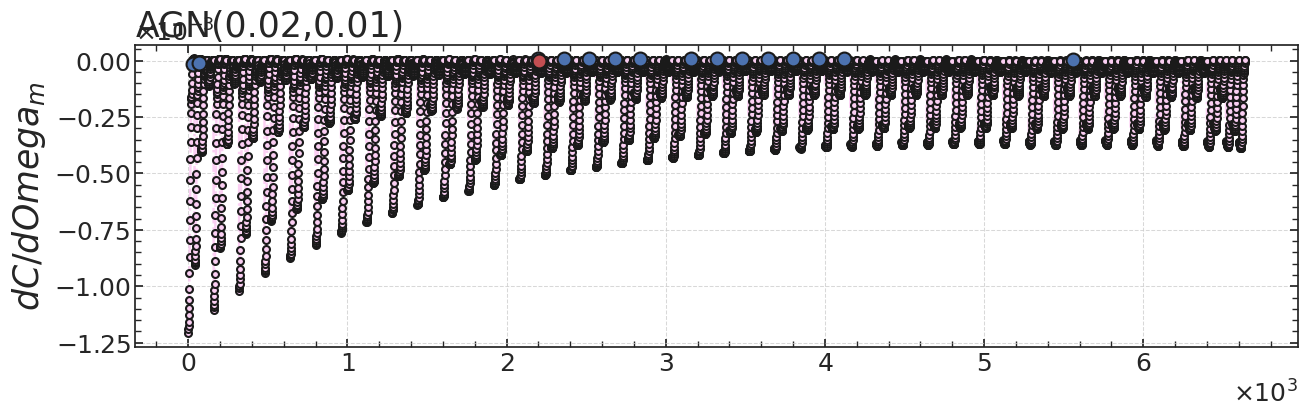

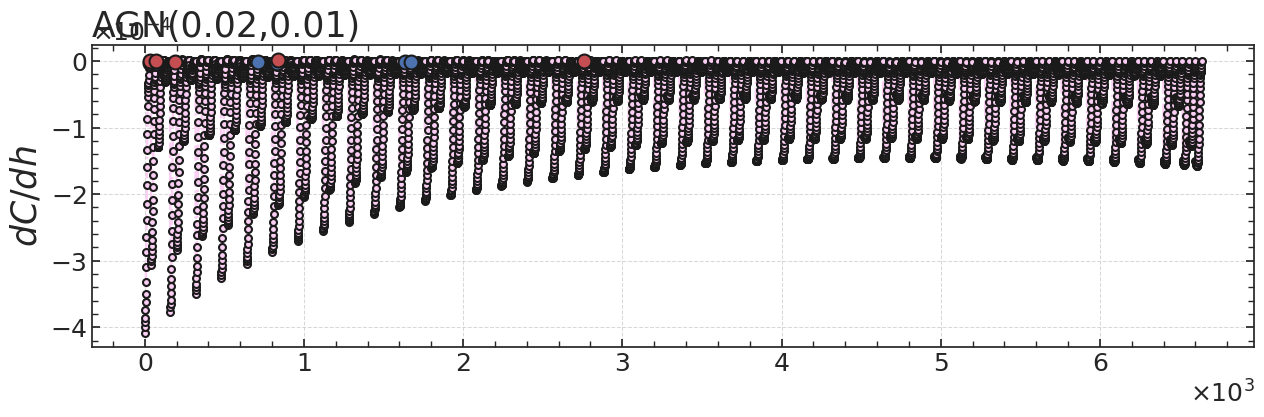

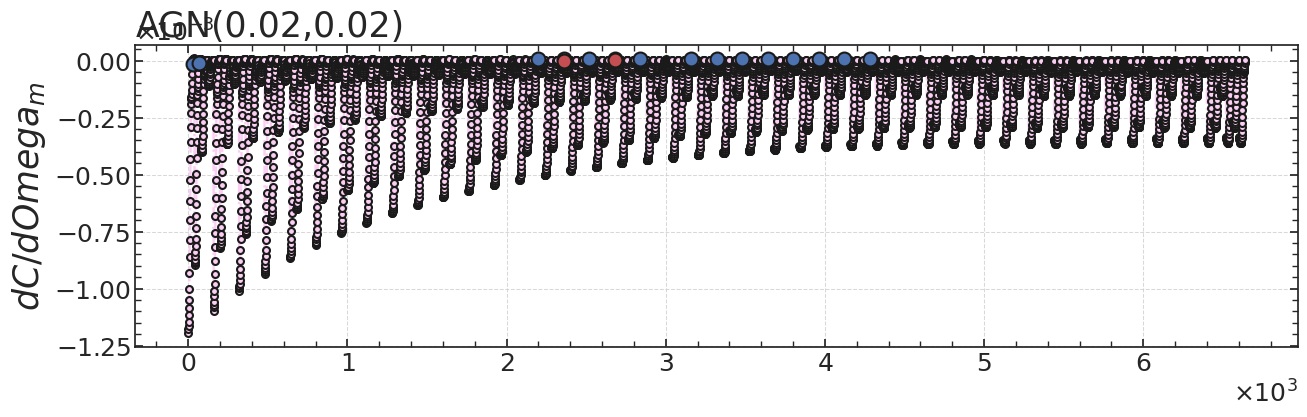

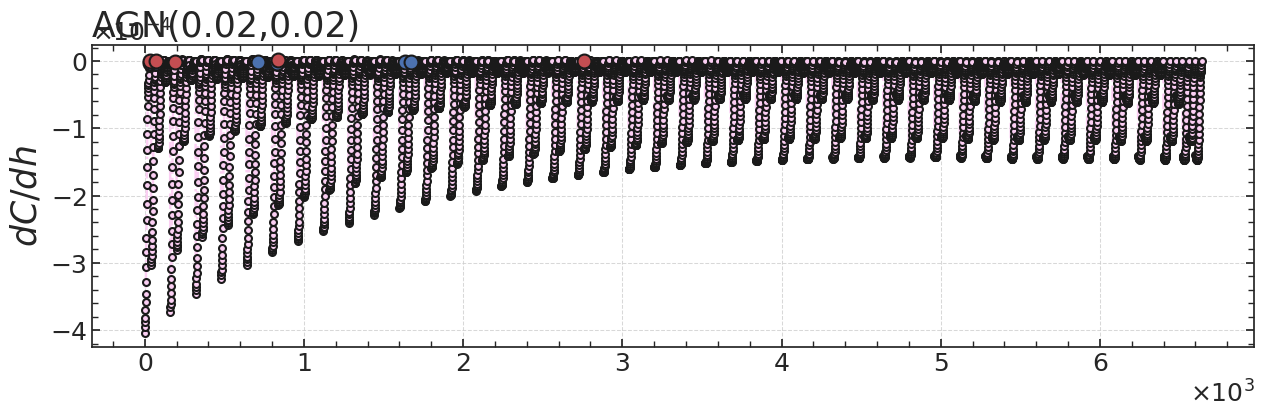

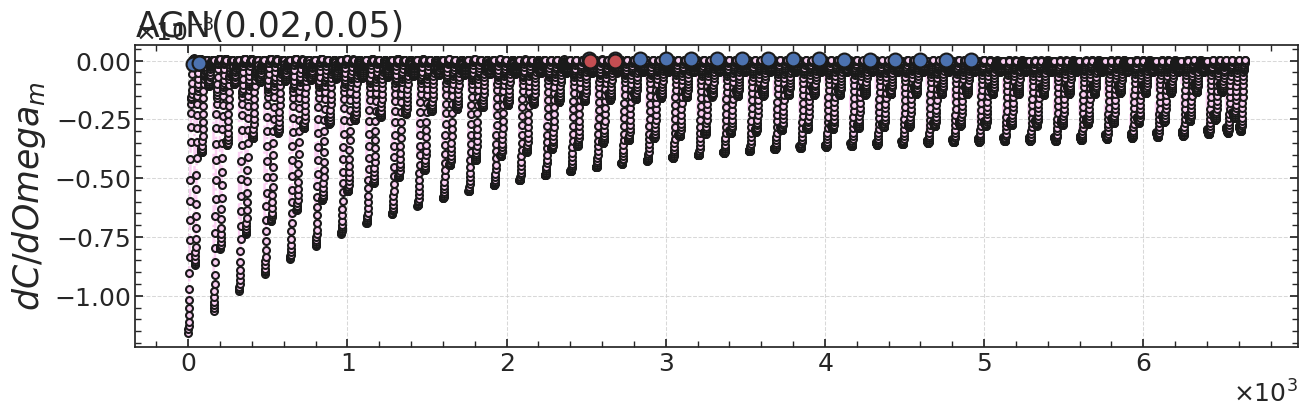

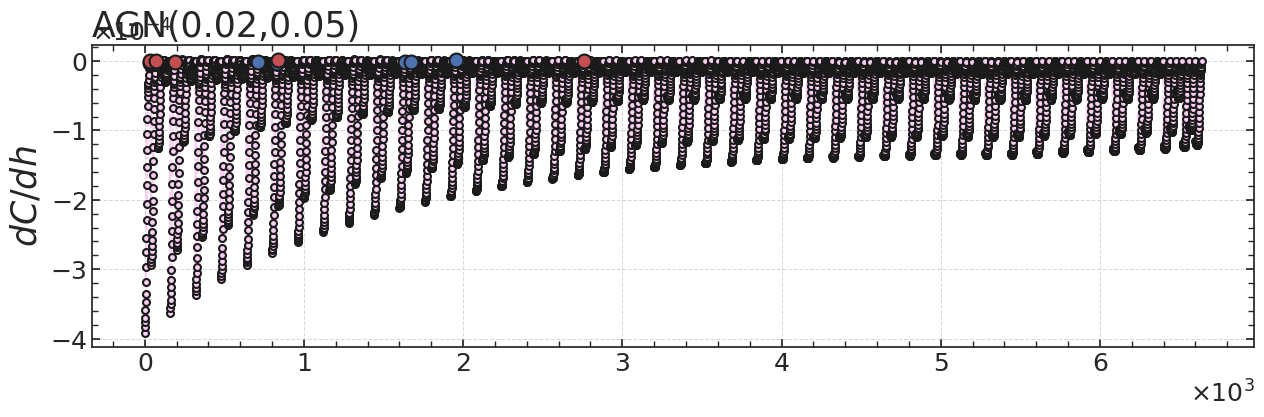

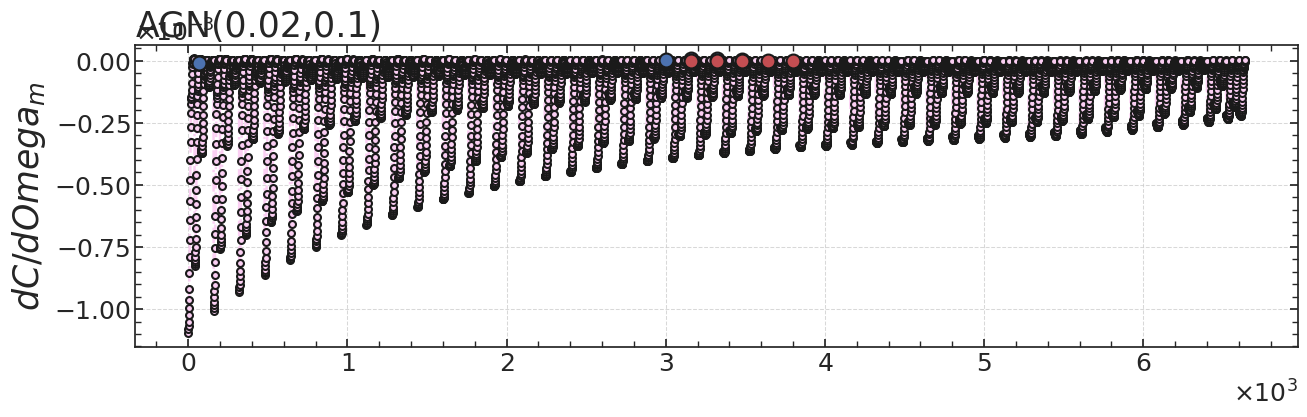

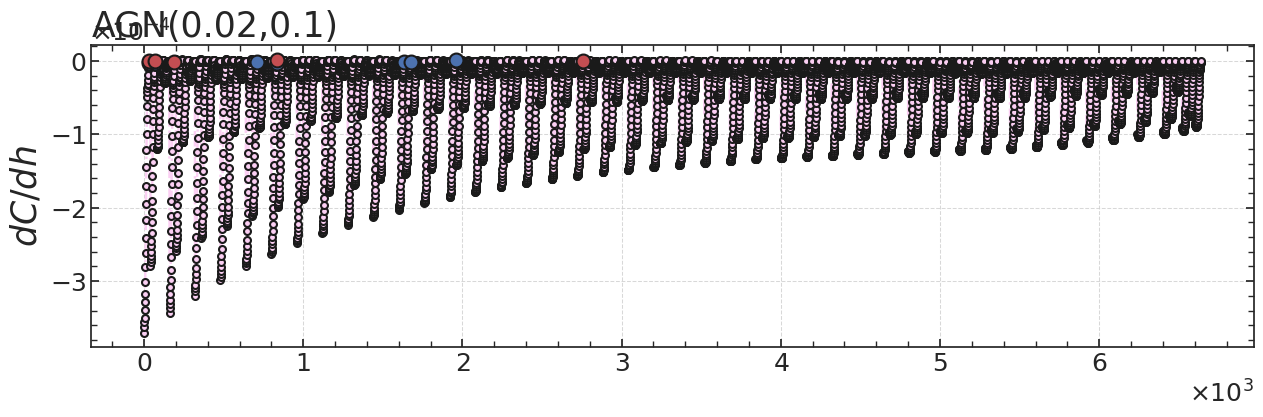

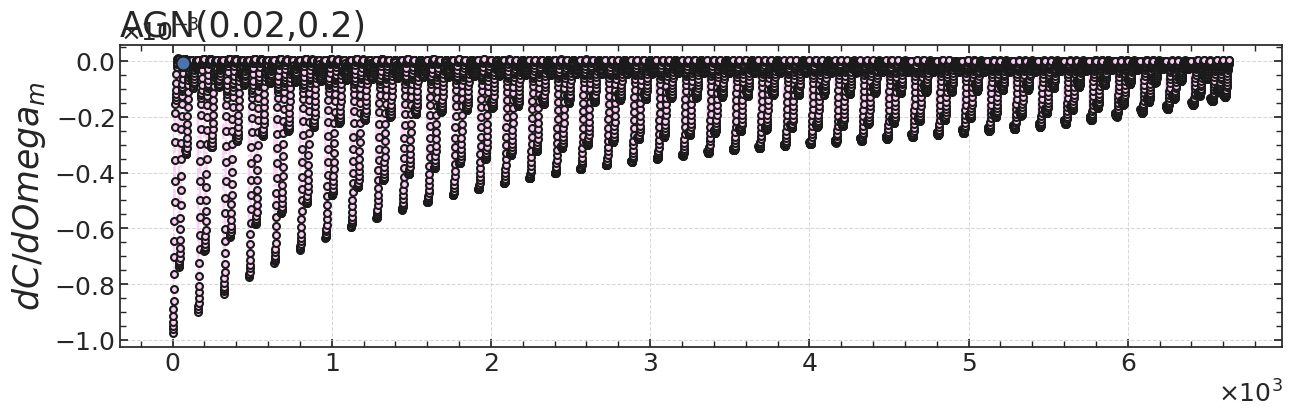

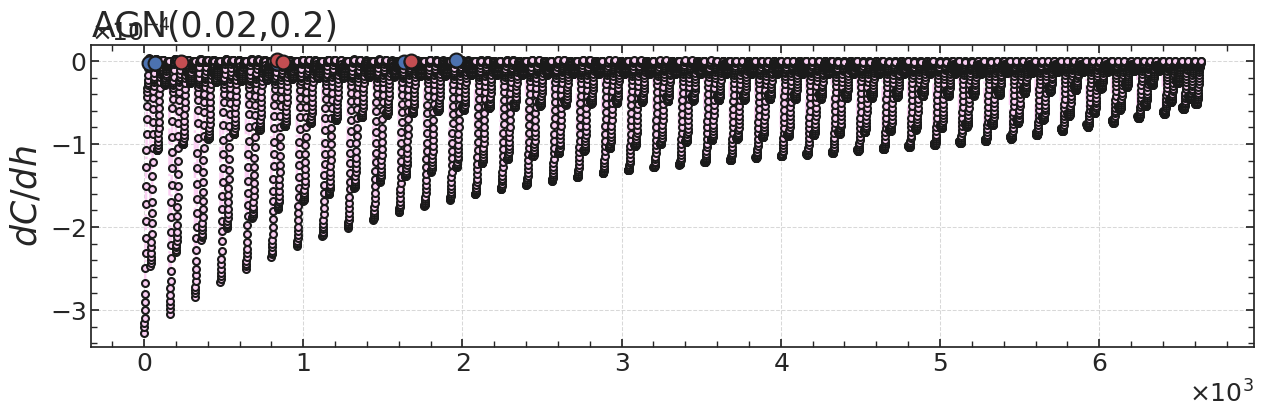

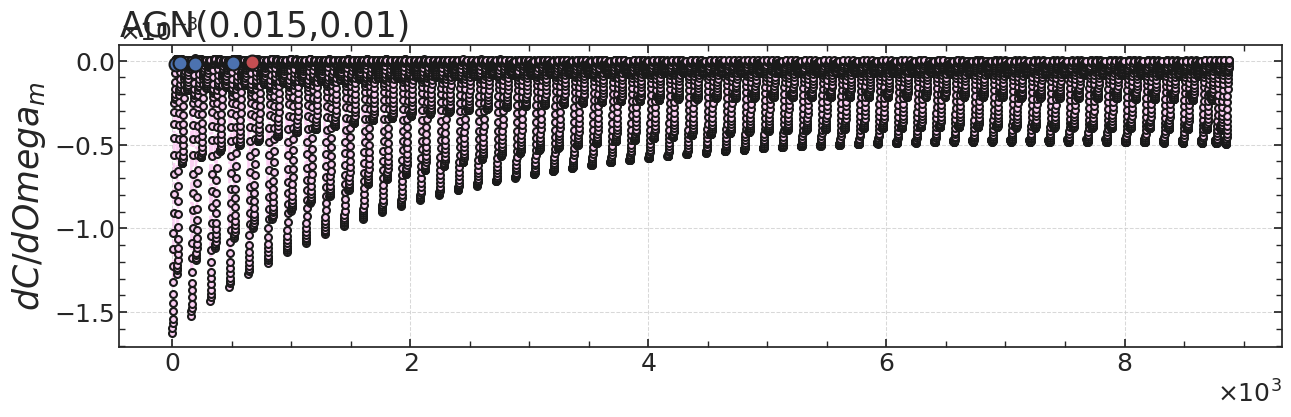

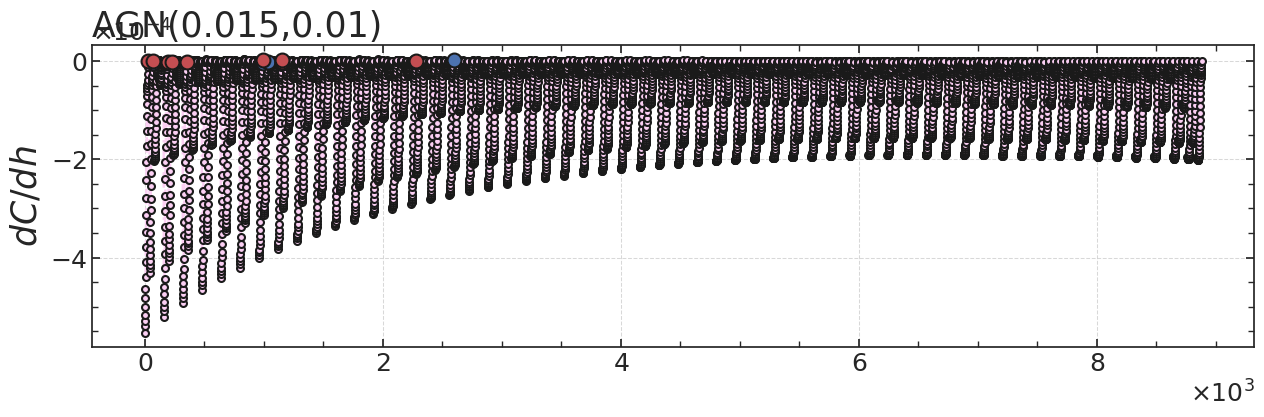

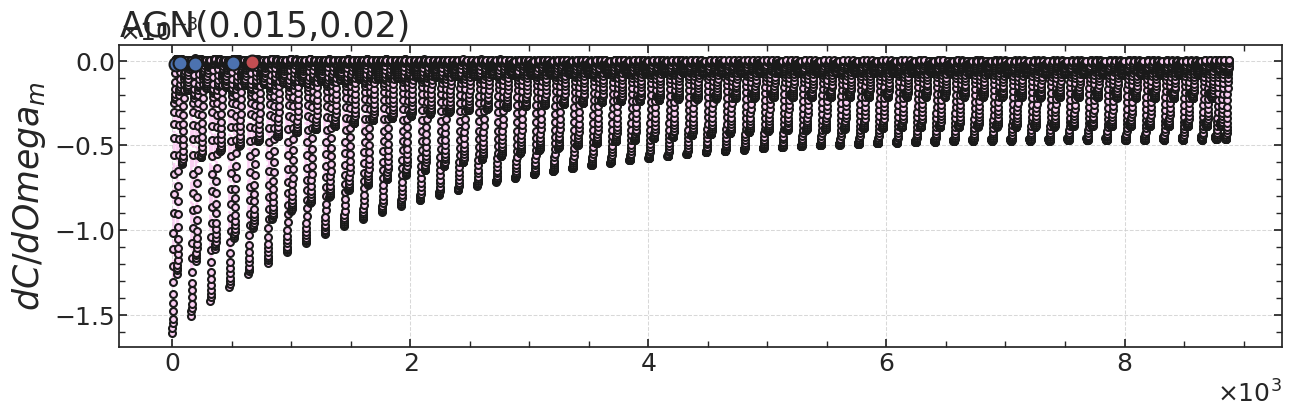

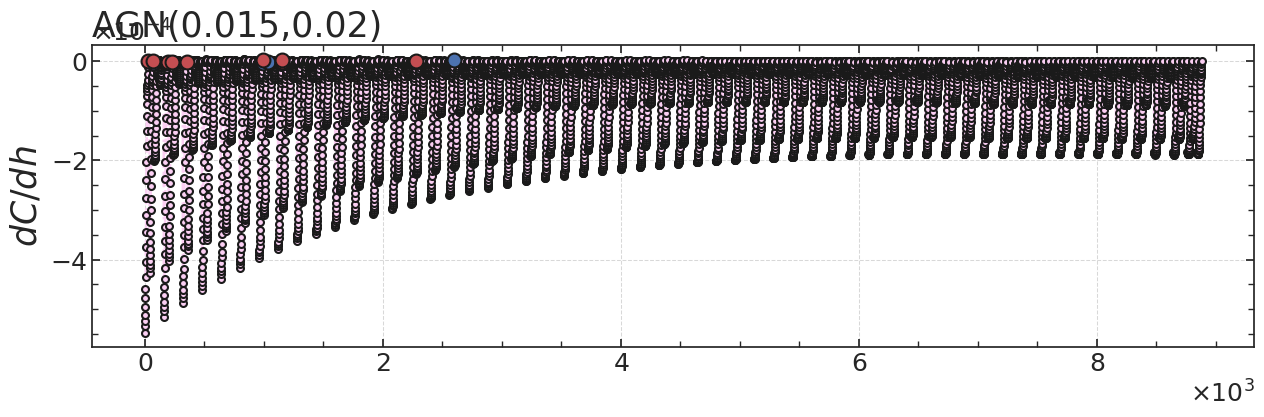

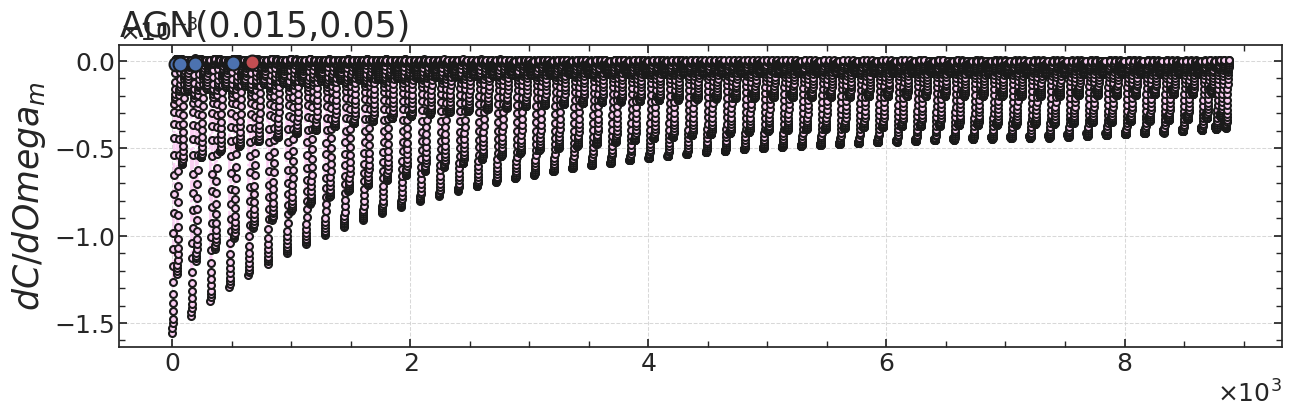

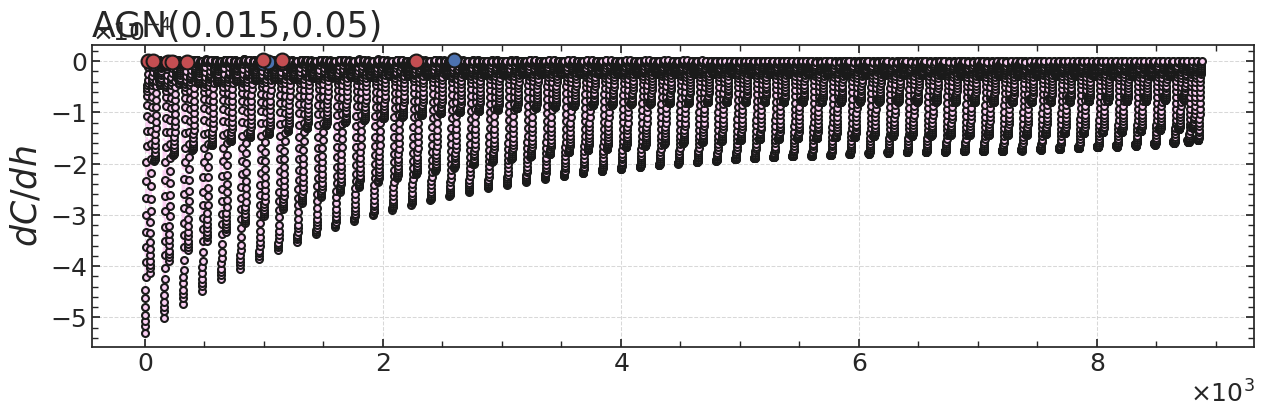

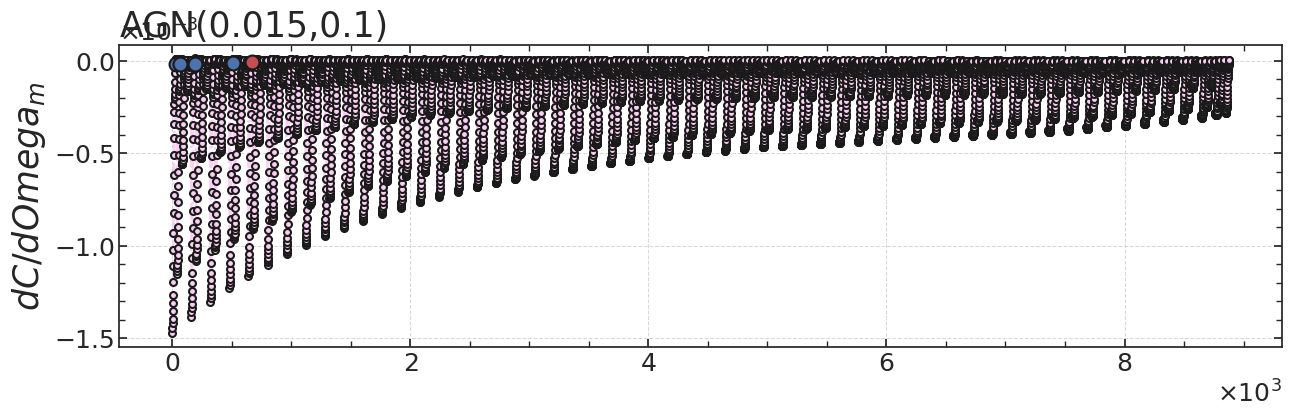

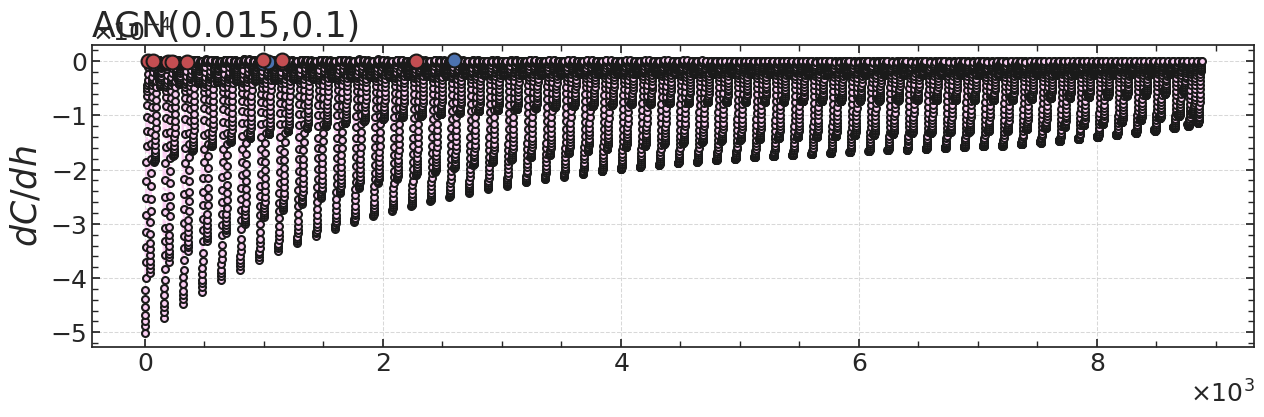

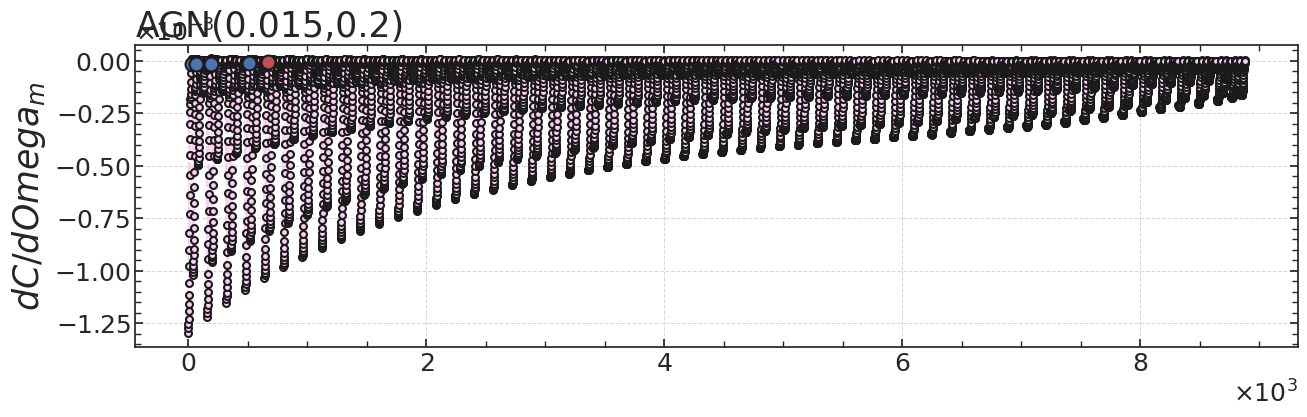

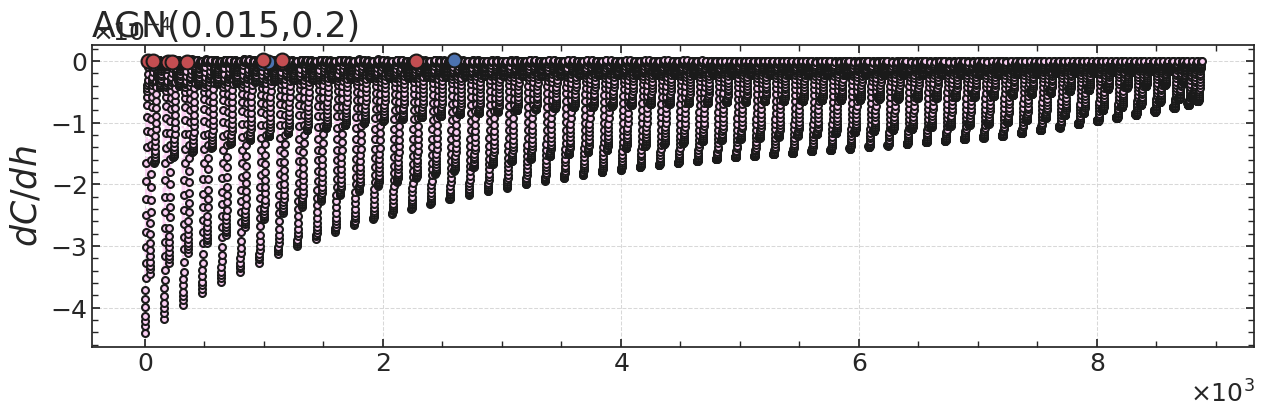

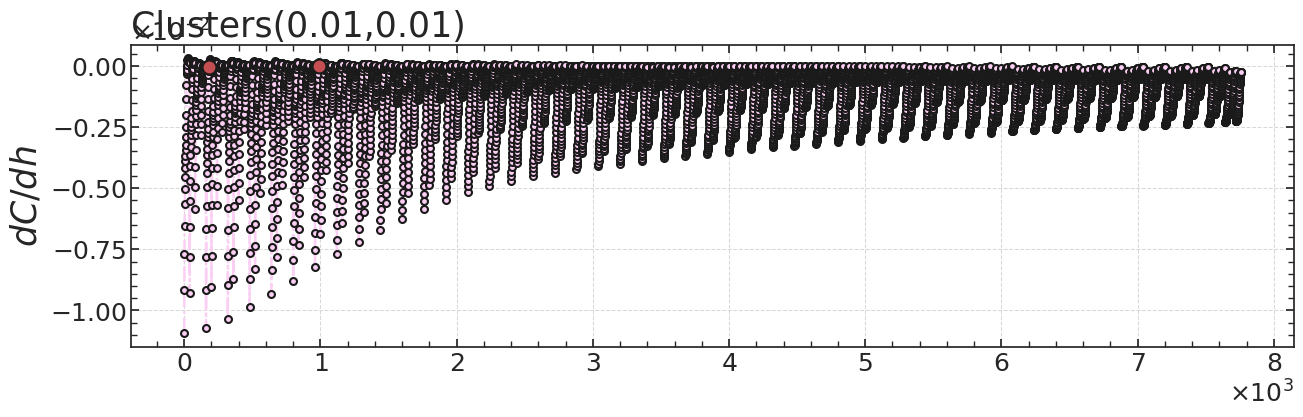

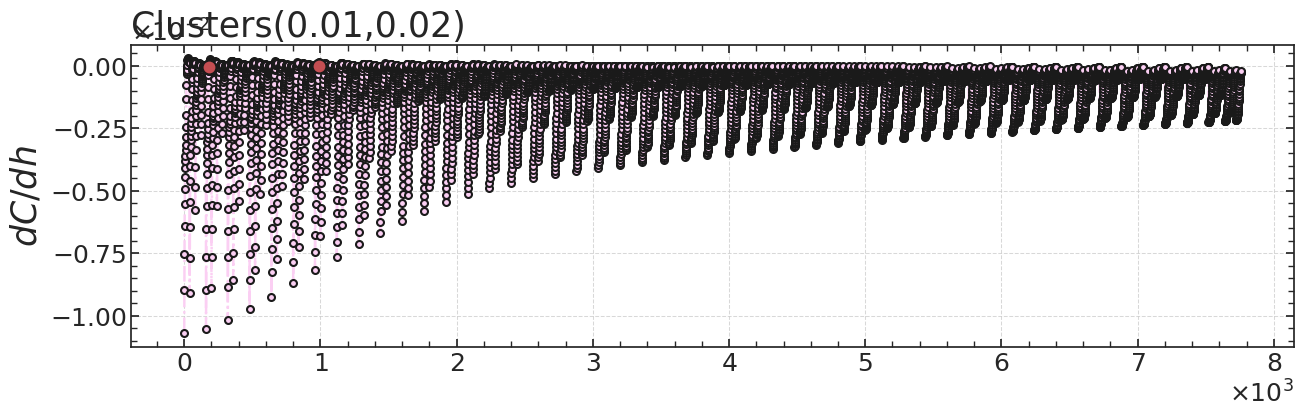

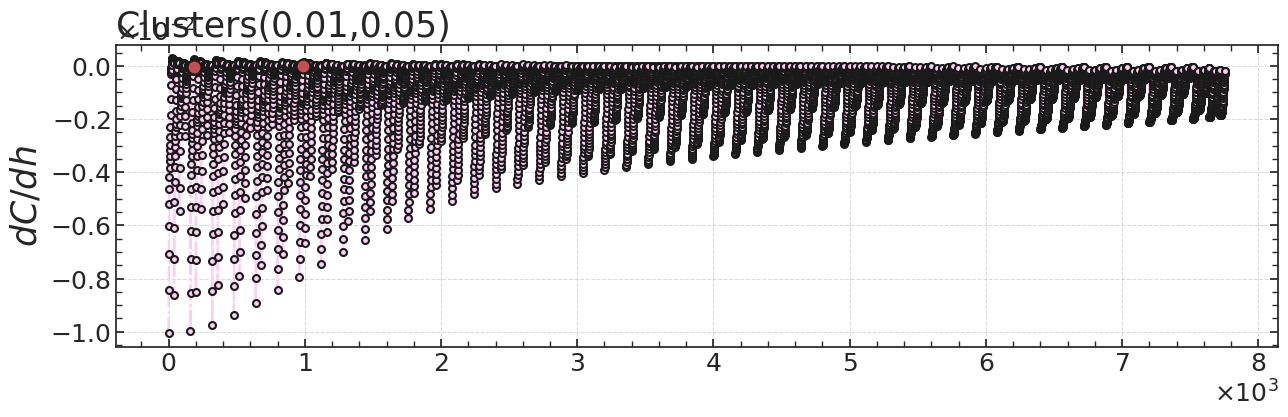

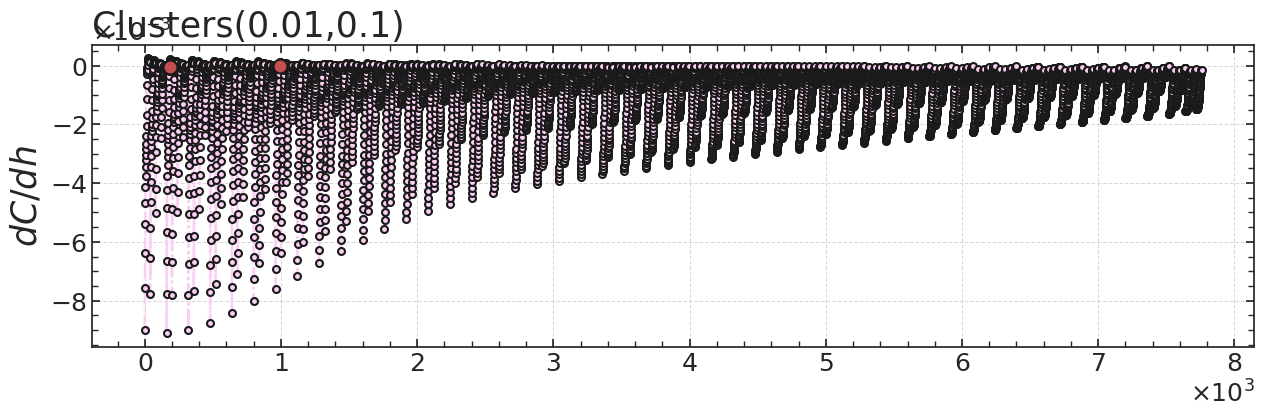

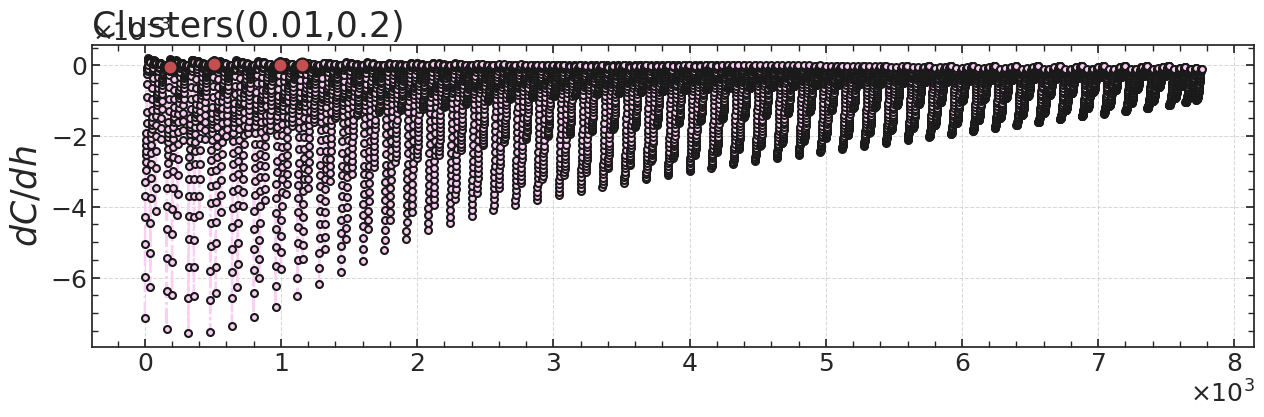

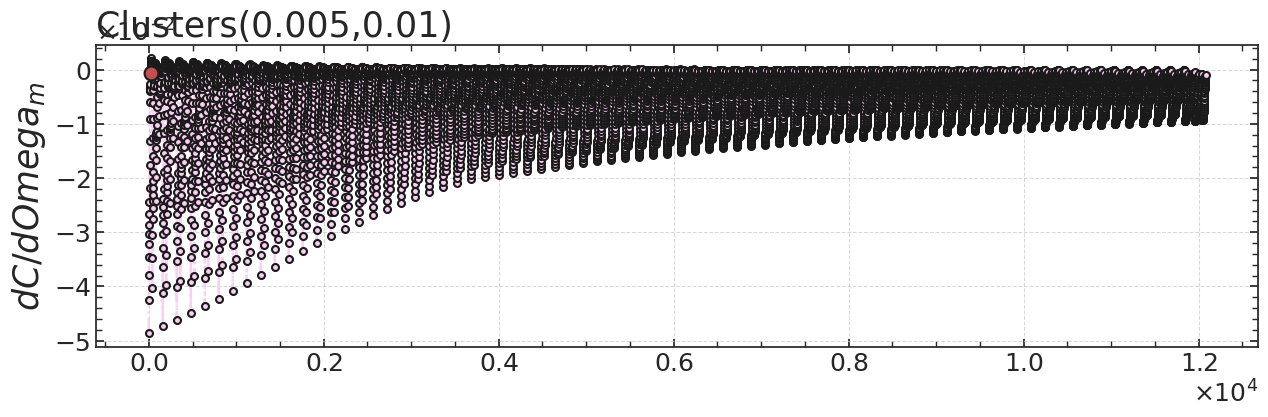

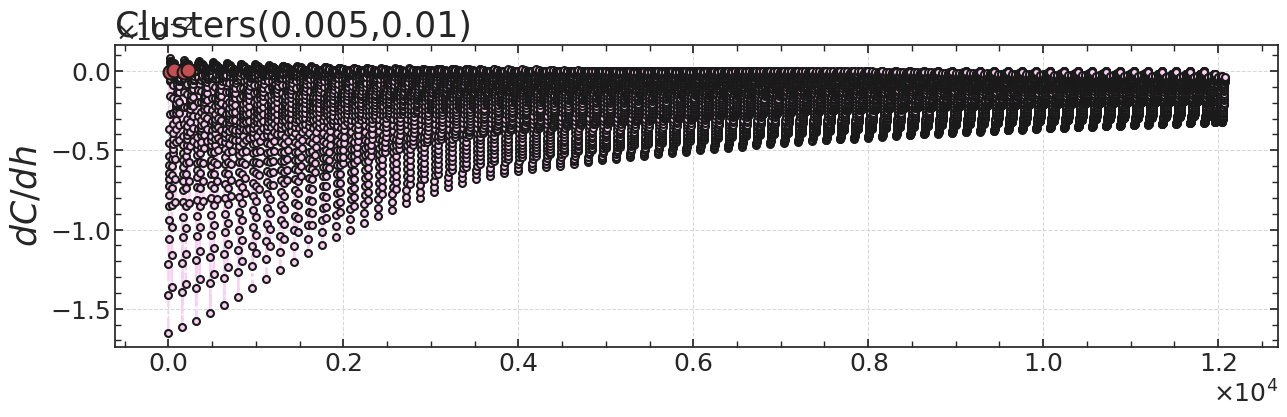

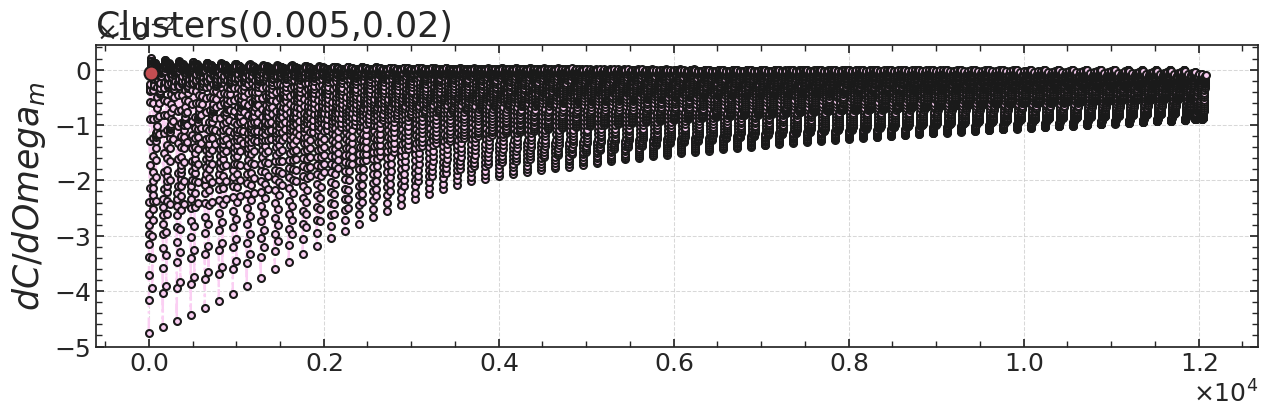

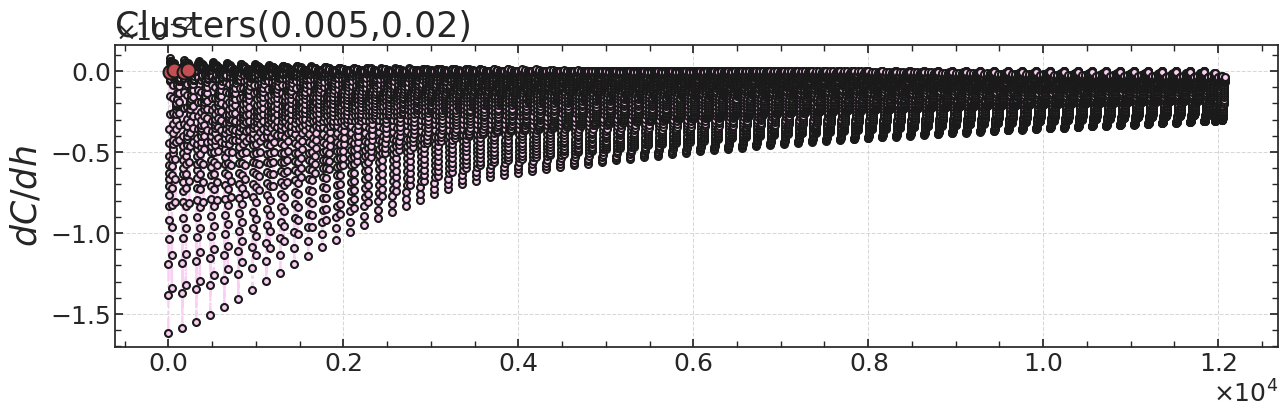

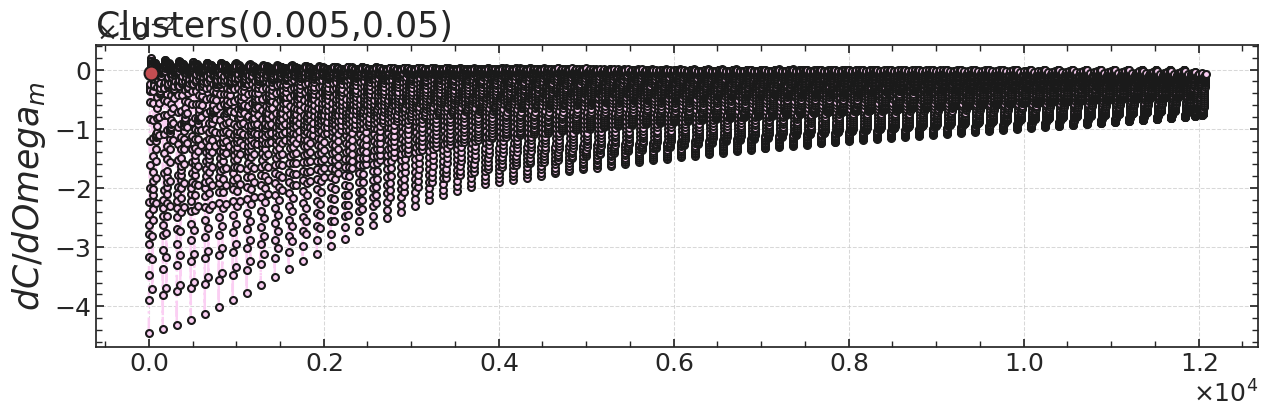

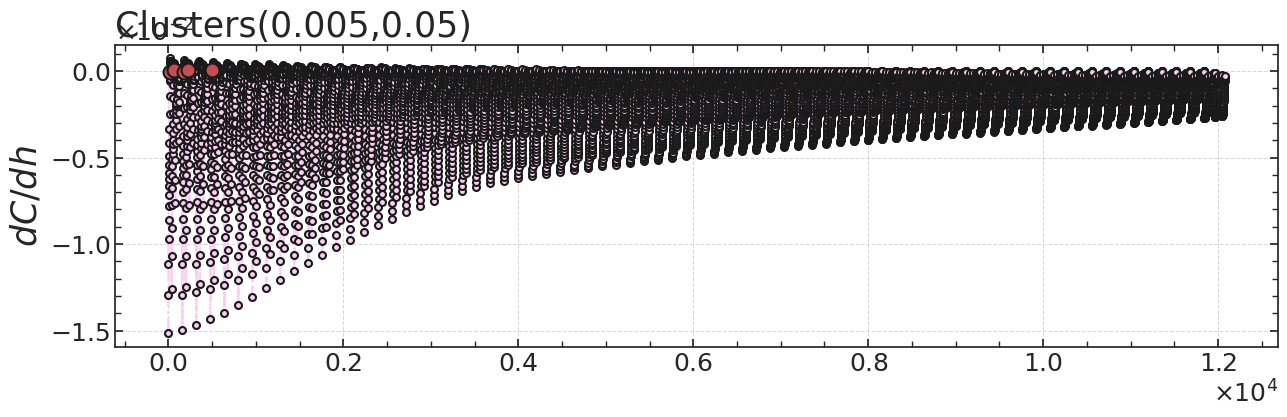

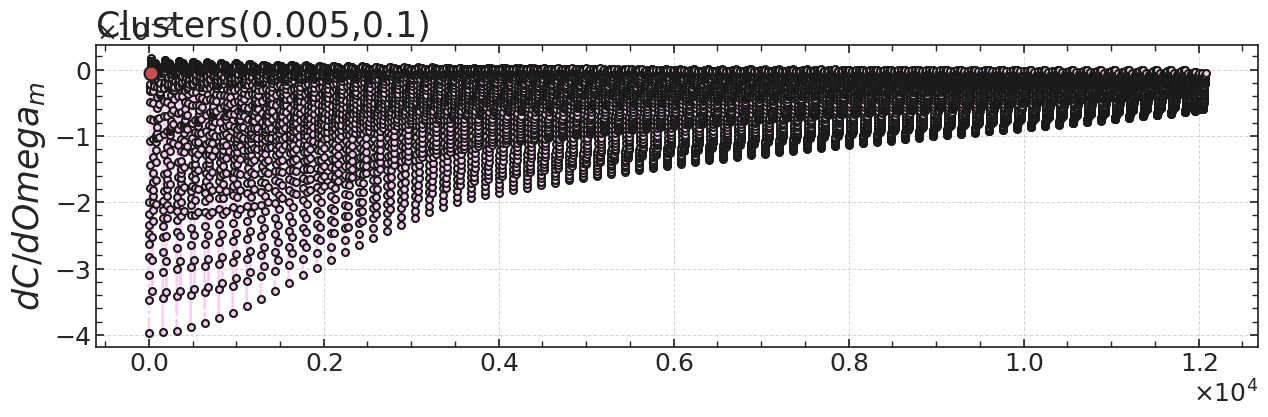

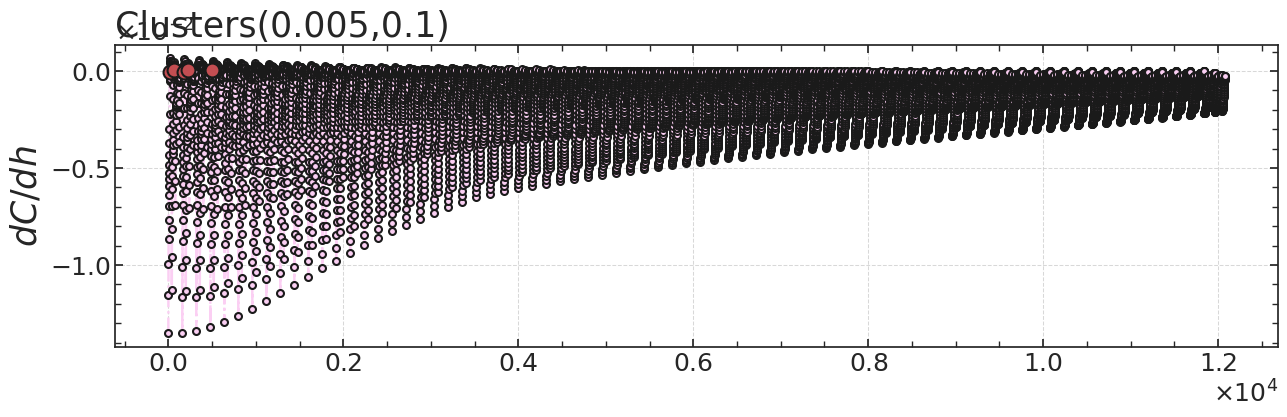

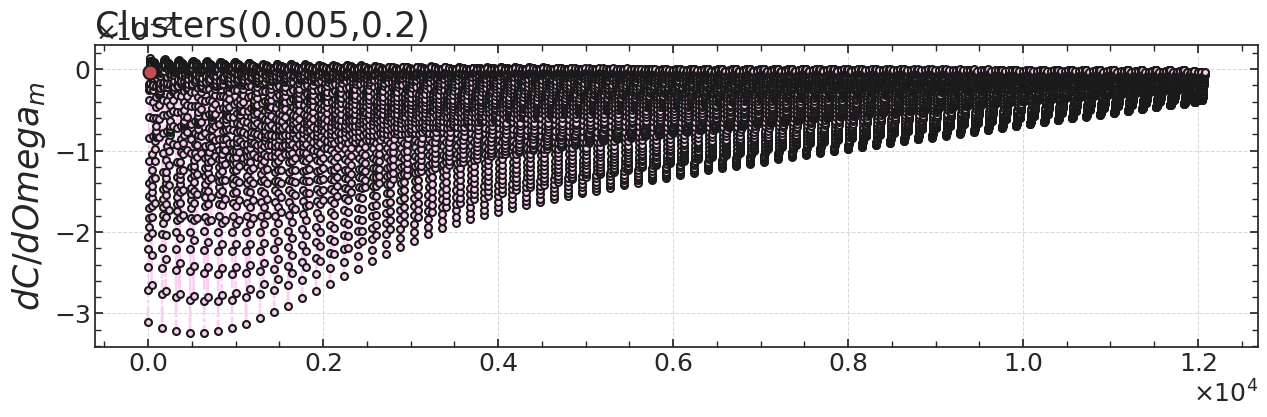

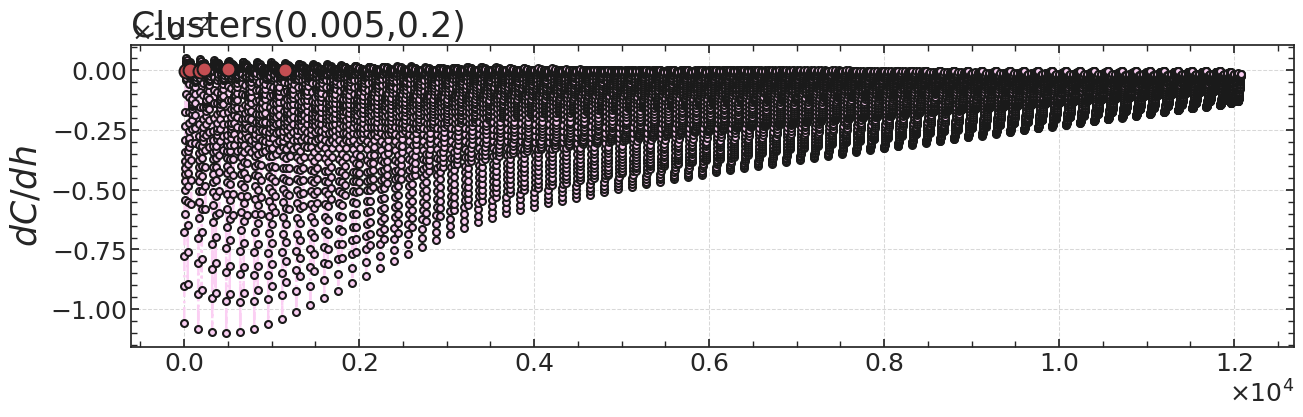

In [11]:
idx = 0
for sigma_0 in sigmas_all:
    for f_fail in f_fails_all:
        F = load_fisher_sigma0_f_fail(sigma_0, f_fail)
        cond1 = ~F[0].check_derivatives(title = F[0].name)
        try:
            cond2 = ~F[1].check_derivatives(title = F[1].name)
        except:
            cond2 = False
        if cond1 or cond2:
            print(f'====== {sigma_0=} {f_fail=}, index = {idx} ====')
        idx += 1
